#**1. Data Collection and Pre-processing**

##**a. Overview**

The dataset was collected from IEEE-CIS Fraud Detection Contest, which was hosted on the Kaggle competition. There are 394 factors related to online tracked transactions and 41 factors associated with the identity of the transactions. Since the dataset was significant, we decided to use Python notebooks to pre-process the dataset, involving partitioning the data by its relationship with the response variable and figuring out a way of filtering N/A variables by its definition and collection process.

Mount and load the data set.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection/

/content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection


In [ ]:
ls

data_final.csv  fraud_net.h5           test_identity.csv     train_identity.csv
dat.zip         sample_submission.csv  test_transaction.csv  train_transaction.csv


In [ ]:
data = "./"
train_iden = data + "train_identity.csv"
test_iden = data + "test_identity.csv"
train_trans = data + "train_transaction.csv"
test_trans = data + "test_transaction.csv"
sample_sub = data + "sample_submission.csv"

Install the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

import os
import tempfile

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold



from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score


from sklearn.feature_selection import VarianceThreshold # Feature selector

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Neural Network
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

## Using K-means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from matplotlib import pyplot
from sklearn.inspection import permutation_importance

Read the datasets and check the dimensions of the training dataset.

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_transaction = pd.read_csv(train_trans)
train_identity = pd.read_csv(train_iden)
train_identity = reduce_mem_usage(train_identity)
# test_identity = reduce_mem_usage(test_identity)
train_transaction = reduce_mem_usage(train_transaction)
# test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [ ]:
# Since the number of columns are too large, we can expand it using pd.set_option()
#pd.set_option('display.max_columns', None)

In [ ]:
train_df = pd.merge(train_transaction, train_identity, on='TransactionID')

In [ ]:
train_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 434 columns):
 #    Column          Dtype  
---   ------          -----  
 0    TransactionID   int32  
 1    isFraud         int8   
 2    TransactionDT   int32  
 3    TransactionAmt  float16
 4    ProductCD       object 
 5    card1           int16  
 6    card2           float16
 7    card3           float16
 8    card4           object 
 9    card5           float16
 10   card6           object 
 11   addr1           float16
 12   addr2           float16
 13   dist1           float16
 14   dist2           float16
 15   P_emaildomain   object 
 16   R_emaildomain   object 
 17   C1              float16
 18   C2              float16
 19   C3              float16
 20   C4              float16
 21   C5              float16
 22   C6              float16
 23   C7              float16
 24   C8              float16
 25   C9              float16
 26   C10             float16
 27   C11         

In [ ]:
label = train_df["isFraud"]
features = train_df.drop("isFraud", axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1, stratify=label)

## **b. Data Pre-processing**

I print the first few lines to see what content is contained in each attributes. The variables' meanings are described below.


*   TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
*   TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.








In [ ]:
X_train.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_37,id_38,DeviceType,DeviceInfo,Popular OS,Browser,P_emaildomain_grouped,DeviceInfo_grouped,Browser_grouped,Popular OS_grouped
102934,3370413,9596428,27.734375,C,1976,545.0,185.0,visa,102.0,credit,...,F,F,mobile,NA,NA,mobile,hotmail.com,NA,mobile,NA
120613,3460162,12236453,100.000000,R,6019,583.0,150.0,visa,226.0,credit,...,T,T,desktop,Trident/7.0,Windows,ie,anonymous.com,Trident/7.0,ie,Windows
41258,3086684,1999814,100.000000,R,12691,555.0,150.0,visa,226.0,debit,...,T,F,mobile,iOS Device,iOS,mobile,gmail.com,iOS Device,mobile,iOS
17174,3038867,1212761,200.000000,R,12341,399.0,150.0,american express,146.0,credit,...,F,F,desktop,MacOS,Mac,safari,gmail.com,MacOS,safari,Mac
139034,3549681,14915944,56.000000,S,15775,481.0,150.0,mastercard,102.0,credit,...,T,F,desktop,Windows,Windows,NA,NA,Windows,NA,Windows


In [ ]:
X_train.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 115386 entries, 102934 to 110830
Data columns (total 310 columns):
 #    Column                 Non-Null Count   Dtype  
---   ------                 --------------   -----  
 0    TransactionID          115386 non-null  int32  
 1    TransactionDT          115386 non-null  int32  
 2    TransactionAmt         115386 non-null  float16
 3    ProductCD              115386 non-null  object 
 4    card1                  115386 non-null  int16  
 5    card2                  114676 non-null  float16
 6    card3                  115256 non-null  float16
 7    card4                  115386 non-null  object 
 8    card5                  114642 non-null  float16
 9    card6                  115386 non-null  object 
 10   addr1                  67069 non-null   float16
 11   addr2                  67069 non-null   float16
 12   P_emaildomain          115386 non-null  object 
 13   R_emaildomain          104862 non-null  object 
 14   C1                

### Handling Missing value

In [ ]:
null_col_check = lambda col: col if train_df[col].isnull().all() == True else None
null_col_lst = list(filter(null_col_check, train_df.columns))

train_df.drop(null_col_lst, axis = 1, inplace = True)

In [ ]:
train_df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 413 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   144233 non-null  int32  
 1    isFraud         144233 non-null  int8   
 2    TransactionDT   144233 non-null  int32  
 3    TransactionAmt  144233 non-null  float16
 4    ProductCD       144233 non-null  object 
 5    card1           144233 non-null  int16  
 6    card2           143331 non-null  float16
 7    card3           144061 non-null  float16
 8    card4           144049 non-null  object 
 9    card5           143277 non-null  float16
 10   card6           144055 non-null  object 
 11   addr1           83786 non-null   float16
 12   addr2           83786 non-null   float16
 13   dist2           37593 non-null   float16
 14   P_emaildomain   130842 non-null  object 
 15   R_emaildomain   131083 non-null  object 
 16   C1              144233 non-null  flo

<Axes: >

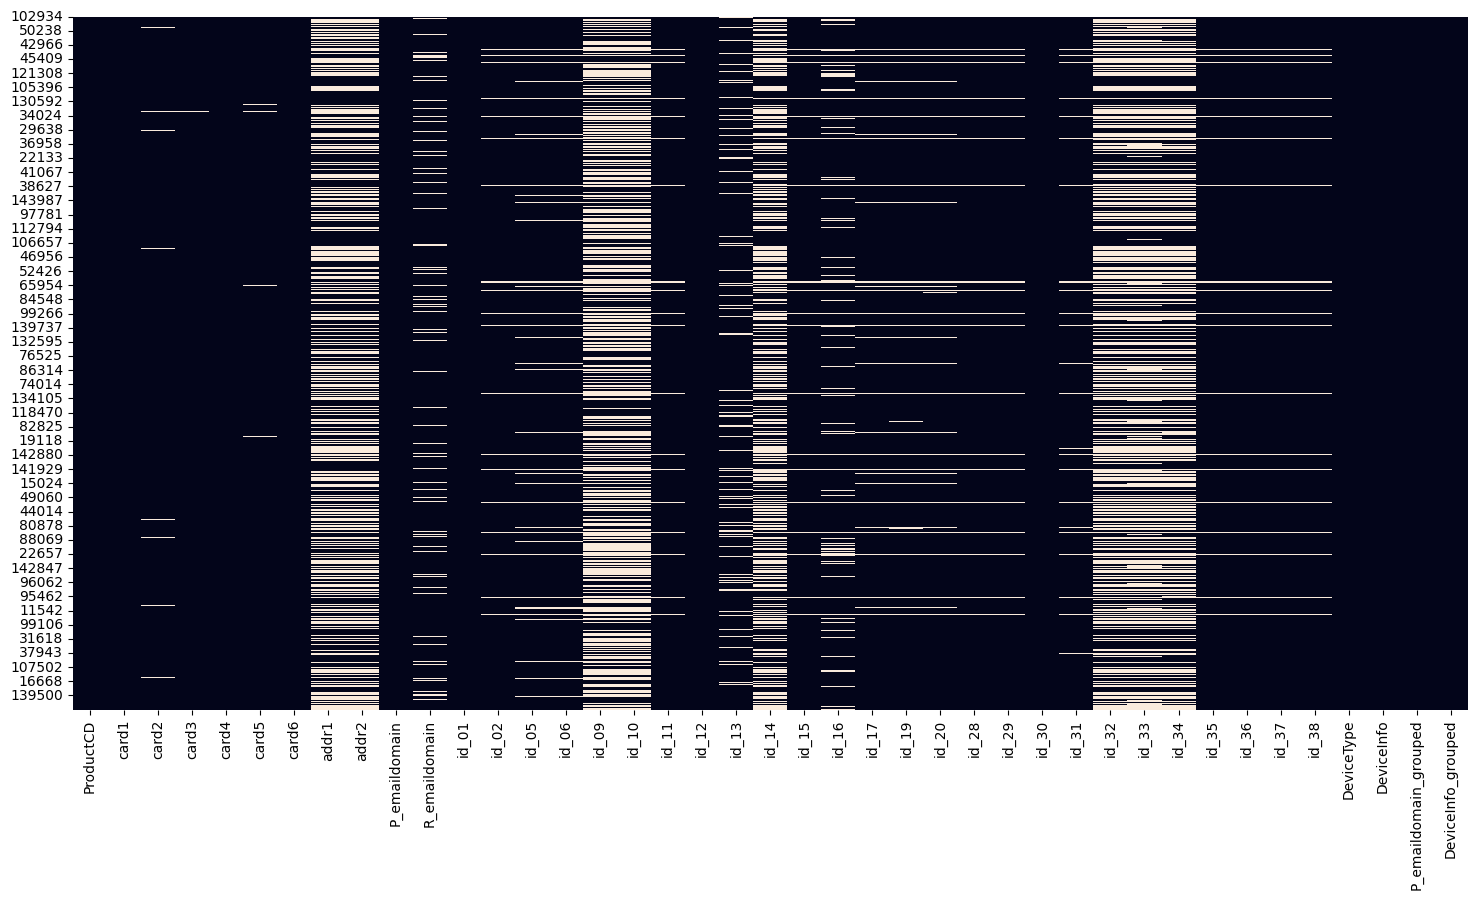

In [ ]:
train_cat = X_train.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo')
plt.figure(figsize=(18,9))
sns.heatmap(train_cat.isnull(), cbar= False)

Has a lot of missing values:

*   We should remove the id_07, 08, and id from 21 to 27
*   Product CD, id_01, id_12, and card 1 tends to be almost non null and unique



In [ ]:
train_cat.filter(regex = 'id_01|id_12|ProductCD|card1').info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 115386 entries, 102934 to 110830
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ProductCD  115386 non-null  object 
 1   card1      115386 non-null  int16  
 2   id_01      115386 non-null  float16
 3   id_12      115386 non-null  object 
dtypes: float16(1), int16(1), object(2)
memory usage: 3.1+ MB


<Axes: >

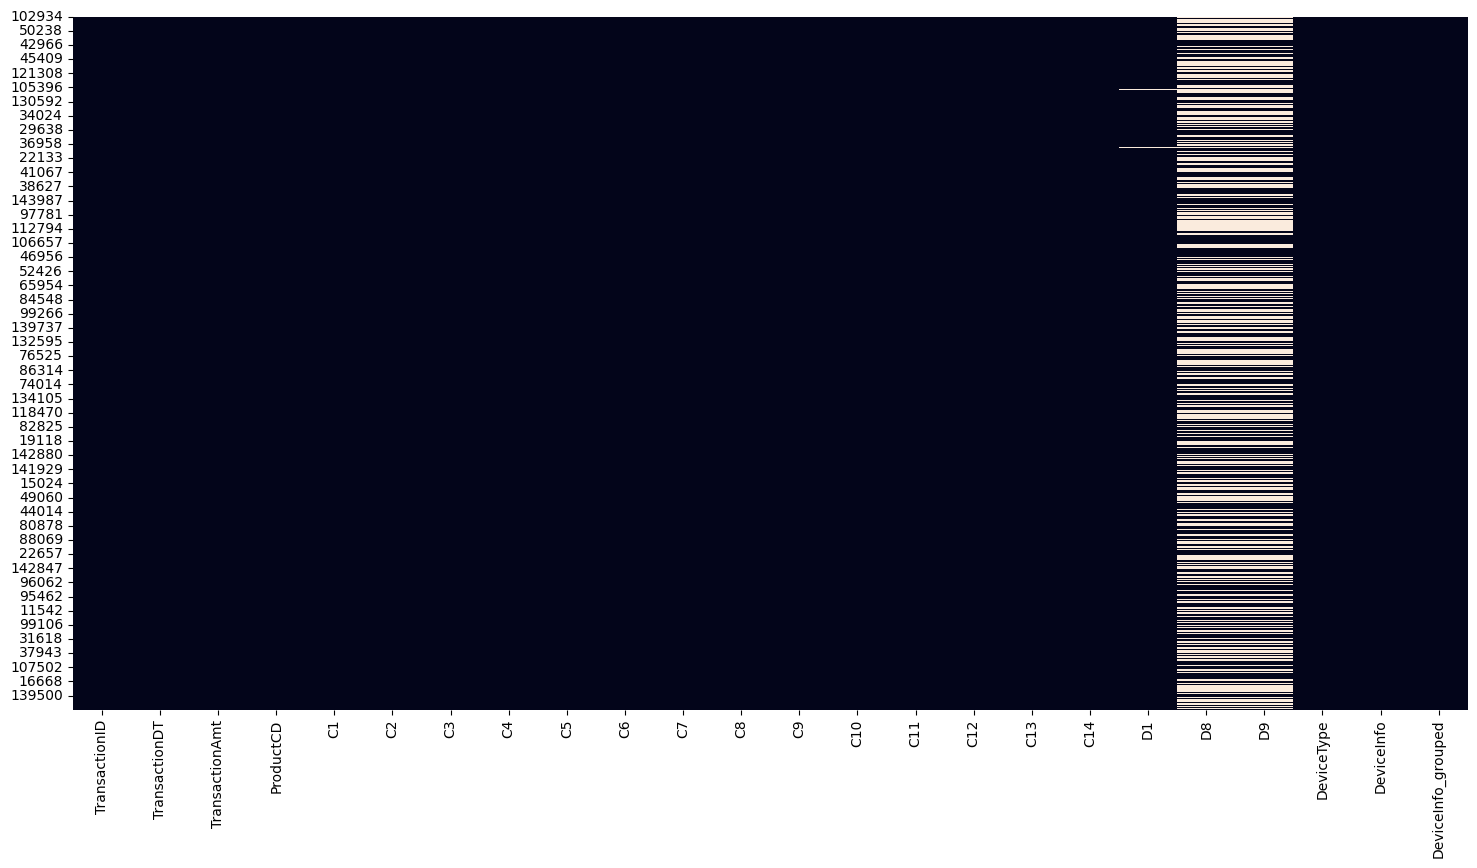

In [ ]:
train_num = X_train.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')
plt.figure(figsize=(18,9))
sns.heatmap(train_num.isnull(), cbar= False)

<Axes: >

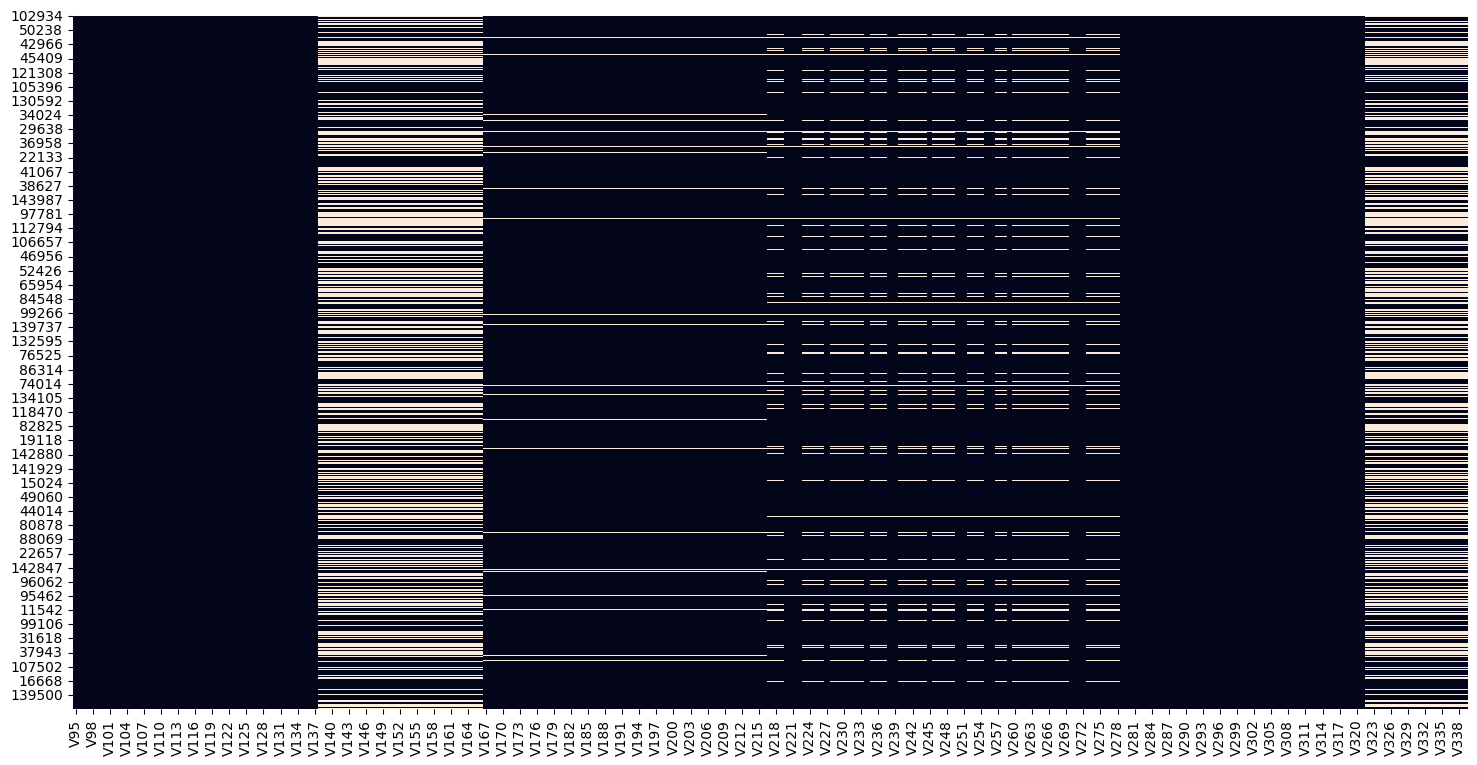

In [ ]:
train_V = X_train.filter(regex='V')
plt.figure(figsize=(18,9))
sns.heatmap(train_V.isnull(), cbar= False)

In [ ]:
threshold = len(X_train) * 0.5
X_train.dropna(thresh=threshold, axis=1, inplace = True)
X_train.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 115386 entries, 102934 to 110830
Data columns (total 310 columns):
 #    Column                 Non-Null Count   Dtype  
---   ------                 --------------   -----  
 0    TransactionID          115386 non-null  int32  
 1    TransactionDT          115386 non-null  int32  
 2    TransactionAmt         115386 non-null  float16
 3    ProductCD              115386 non-null  object 
 4    card1                  115386 non-null  int16  
 5    card2                  114676 non-null  float16
 6    card3                  115256 non-null  float16
 7    card4                  115386 non-null  object 
 8    card5                  114642 non-null  float16
 9    card6                  115386 non-null  object 
 10   addr1                  67069 non-null   float16
 11   addr2                  67069 non-null   float16
 12   P_emaildomain          115386 non-null  object 
 13   R_emaildomain          104862 non-null  object 
 14   C1                

 Variables C1-C14 are the counts of how many addresses are found to be associated with the payment card, phone number, email, device, billing, etc. The actual meaning is masked due to confidentiality.

The N/A values would be removed when making aggregated calculations or statistical summary on those factors since they are specific to each transaction, making them individually independent of each other. Thus, we cannot replace those values with the nearest non-N/A value or regarding them as 0, which makes the analysis seem to be vague.


Since the Vxx attributes contain mostly of null values and the meaning of Cxx columns are not clearly described since the actual meaning is masked, I decide to drop those columns.
The rest of the attributes seem fine to me, but assume that fraud can only be committed by the the purchaser, I also filter out the "R_emaildomain."

Here are the assumption that I came up with:

* The distance from the site’s location where items were sold (location of the seller) to the purchaser’s location is positively correlated with the probability of a fraudulent transaction.
* Some unpopular email domains used by the purchasers might be suspicious of a fraudulent transaction.
* The number of decimal places in the transaction amount can provide suspicious information for determining a fraudulent transaction.
* There should not be any difference among different cards used for transactions in determining the probability of a fraudulent transaction.




#**2. Exploratory Data Analysis**

## Categorical Features



*   ProductCD

* card1 - card6

* addr1, addr2

* Pemaildomain Remaildomain

* M1 - M9







### ProductCD

In [ ]:
def cat_var_fraud_rate(col, df = train_df):
  train_df[col].fillna("NA", inplace = True)
  fraud_rate = df[[col, 'isFraud']].groupby([col], as_index = False).mean()

  plt.figure(figsize = (14, 6))
  g = sns.countplot(x = col, data = df, order = fraud_rate[col])
  g.set_title('Fraud Rate and Count of {}'.format(col), fontsize = 15)
  g.set_xlabel("{}".format(col), fontsize=15)
  g.set_ylabel("Count", fontsize=15)
  plt.xticks(rotation= "vertical")

  g_sub = g.twinx()
  g_sub = sns.pointplot(x = fraud_rate[col], y = fraud_rate['isFraud'], color = "blue")
  g_sub.set_ylabel("Fraud Rate", fontsize = 16)

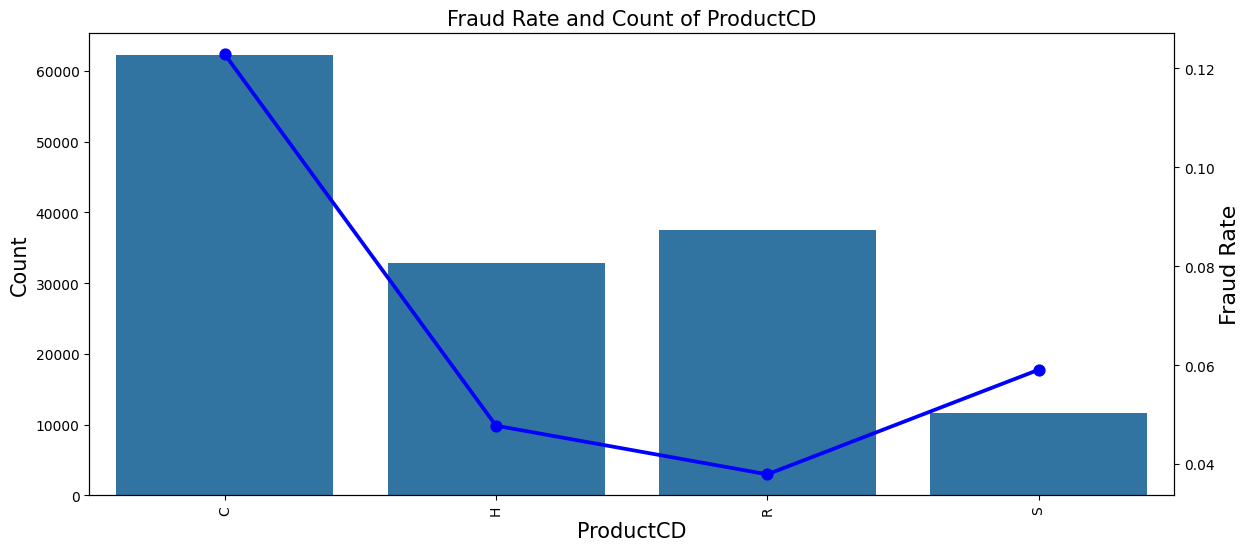

In [ ]:
cat_var_fraud_rate("ProductCD")

 Product C takes up 67.5% of fraud cases for transactions that have identity. And also have highest rate of fraud: 12%, more than double any other class of product. Product H although have less transactions however much higher fraud rate that Product R. Curious in this one, we can see use the *Transaction Amount*

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

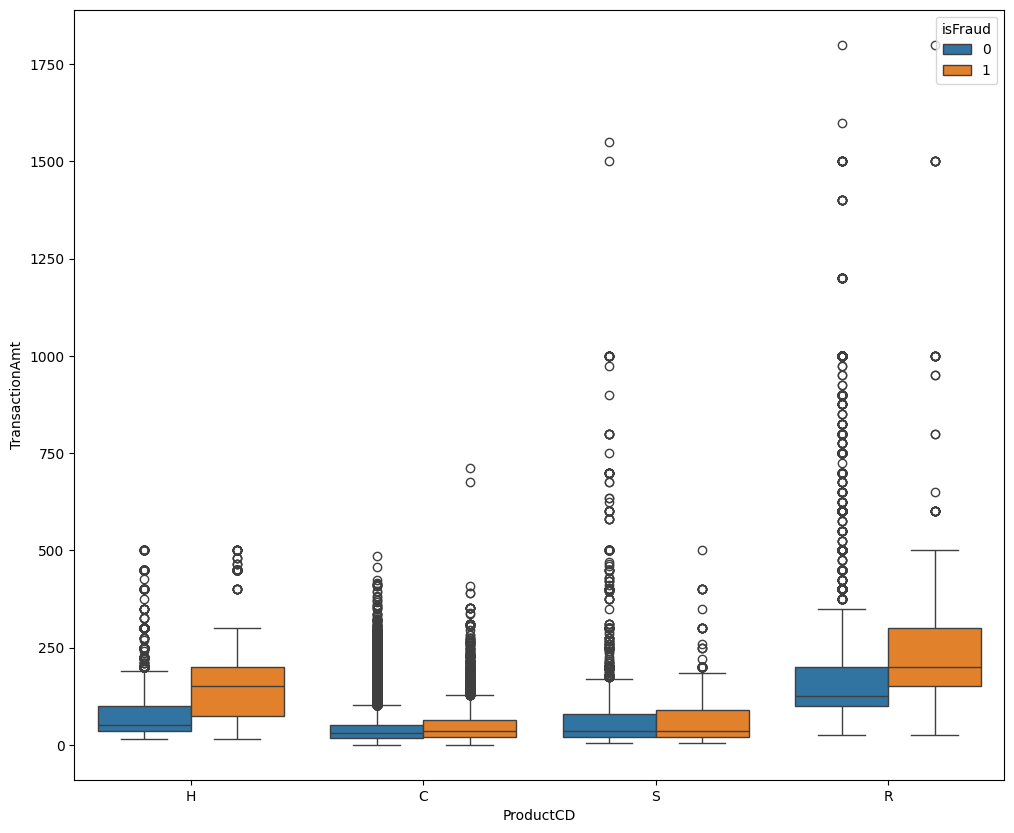

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train_df)

Product C and S are the one with lower transaction amount range

### Card:


1.   Card1-6: Learn why is's categorized as categorical number:
Since Card 1 has so much unique value, it might be the cardID. Card2, Card3, and Card5 also have so much unique values, this also might due to some tokenize algorithm instead of useful data. Therefore, we should care more about Card 4 and Card6



In [ ]:
train_df.loc[:,'card1':'card6'].nunique()

,0
card1,8499
card2,482
card3,103
card4,4
card5,106
card6,3


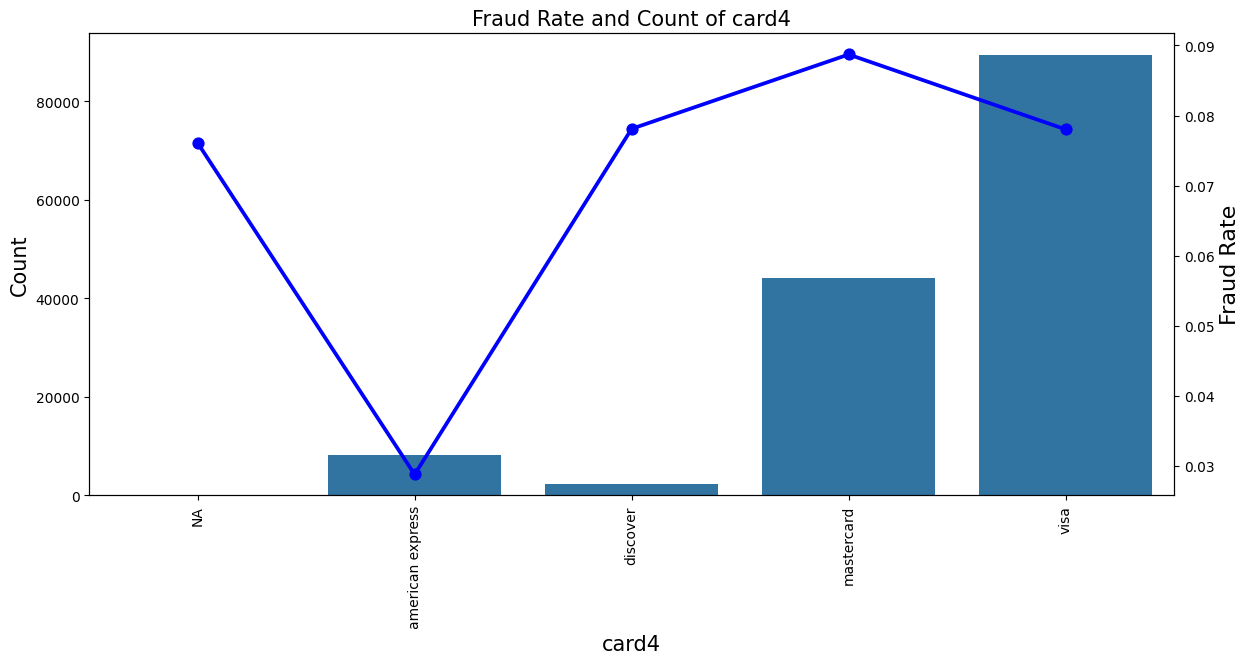

In [ ]:
cat_var_fraud_rate("card4")

In [ ]:
train_df[train_df['isFraud'] == 1]['card4'].value_counts(normalize = True)

,proportion
card4,
visa,0.615656
mastercard,0.346351
american express,0.021117
discover,0.015639
NA,0.001237


Visa Card represents nearly 62% of all transactions with identity, also with highest fraud rate. However, they share similar fraud rate with Mastercard and Discover, althoug two of those types represents much lower proportion of total transactions with identity.

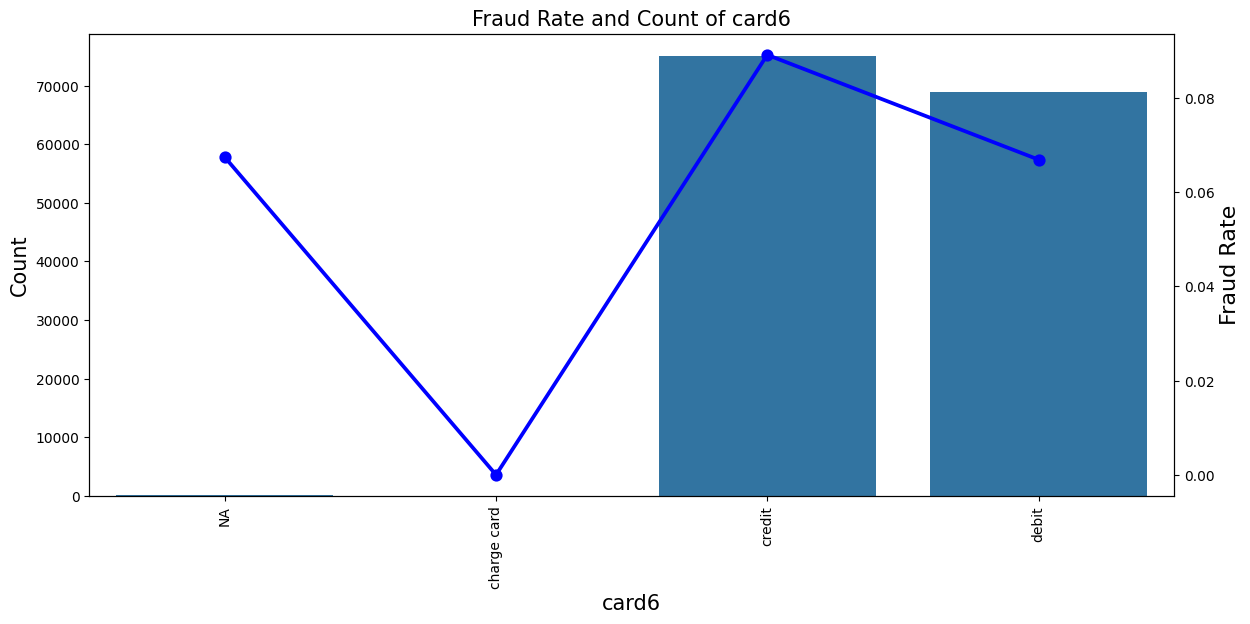

In [ ]:
cat_var_fraud_rate("card6")

In [ ]:
train_df[train_df['isFraud'] == 1]['card6'].value_counts(normalize = True)

,proportion
card6,
credit,0.591359
debit,0.407581
NA,0.001060


There's not much difference between the two cards

### Email Domain

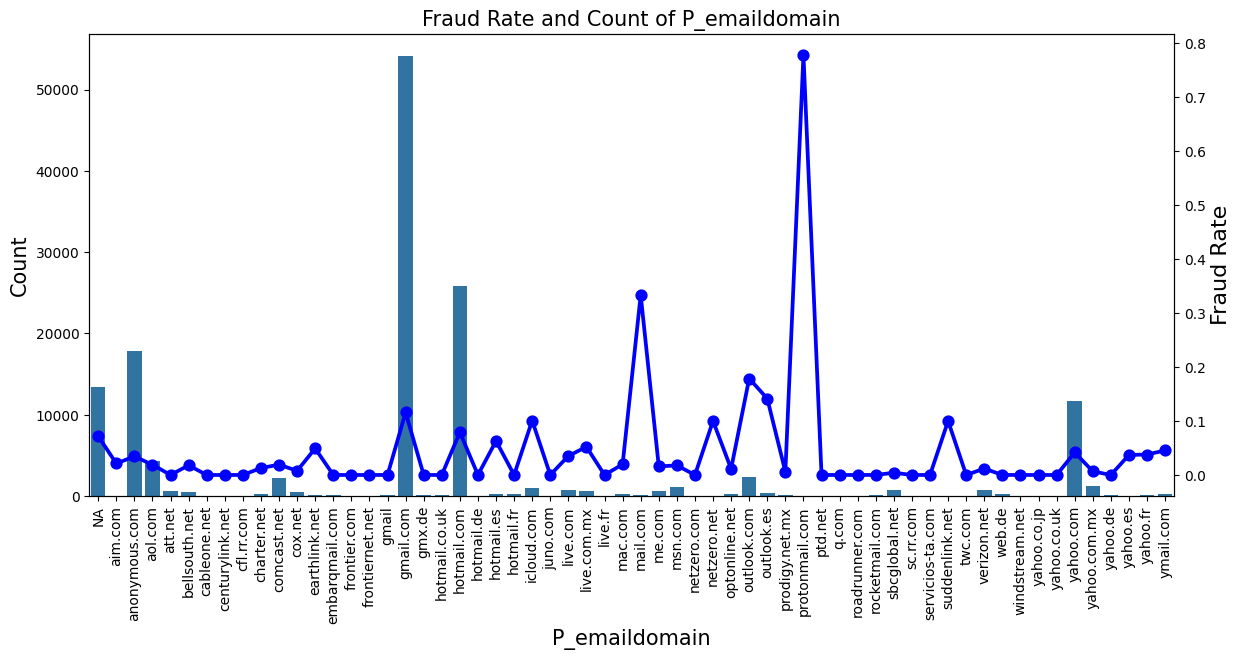

In [ ]:
cat_var_fraud_rate("P_emaildomain")

In [ ]:
email_domainFraud = train_df["isFraud"].eq(1).groupby(train_df["P_emaildomain"]).mean().reset_index()

<ipython-input-32-c0be0c38dd19>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="P_emaildomain", y="isFraud", data=email_domainFraud_sorted, palette="Oranges")


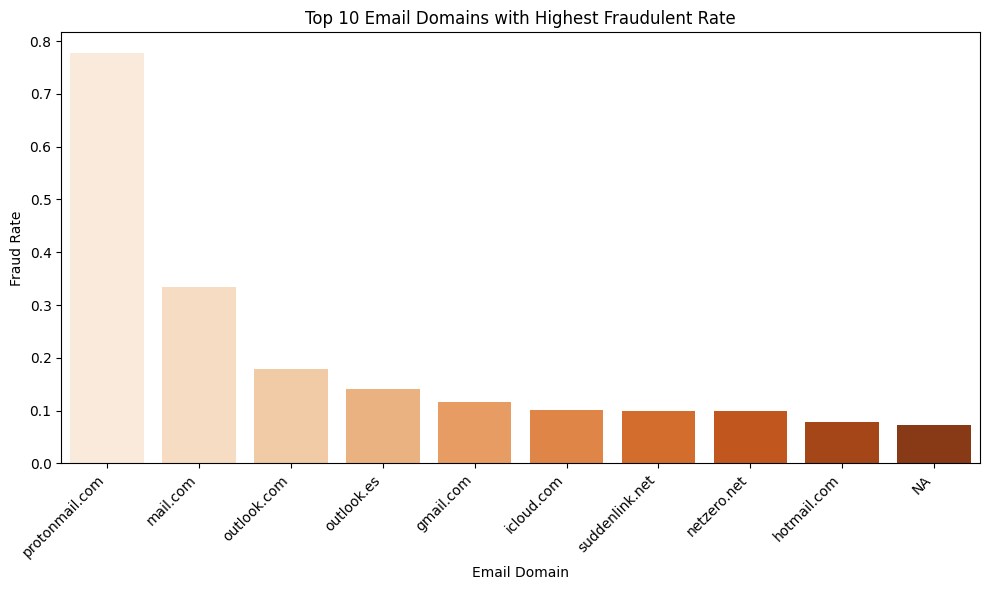

In [ ]:

email_domainFraud = train_df["isFraud"].eq(1).groupby(train_df["P_emaildomain"]).mean().reset_index()
email_domainFraud_sorted = email_domainFraud.sort_values(by="isFraud", ascending=False).head(10)


plt.figure(figsize=(10, 6))
sns.barplot(x="P_emaildomain", y="isFraud", data=email_domainFraud_sorted, palette="Oranges")

plt.xlabel('Email Domain')
plt.ylabel('Fraud Rate')
plt.title('Top 10 Email Domains with Highest Fraudulent Rate')
plt.xticks(rotation=45, ha="right")  # Rotate x-labels for better readability
plt.tight_layout()

plt.show()

In [ ]:
email_counts = train_df["P_emaildomain"].value_counts()
train_df['P_emaildomain_grouped'] = train_df['P_emaildomain'].apply(lambda x: x if email_counts[x] >= 1000 else 'Others')
train_df["P_emaildomain_grouped"].value_counts()

,count
P_emaildomain_grouped,
gmail.com,54140
hotmail.com,25782
anonymous.com,17840
NA,13391
yahoo.com,11667
Others,9292
aol.com,4306
outlook.com,2346
comcast.net,2196


I investigate whether some specific email domains are correlated with committing fraud since less common email domains may have weaker online security and verification methods. The table above shows the top 5 of the purchaser email domains that have the highest probability of committing fraud, which is approximately 10%, at least. Protonmail.com purchasers perpetrate credit card fraud the most frequently, with 40.7% of them doing so. As research further, protonmail.com is a free encrypted email domain, making it much more difficult to track users’ information and thus make it easier to perform fraud. Other domains include mail.com and aim.com, both of which are relatively obscure with little ìnformation found on the internet. On the other hand, a well-known domain such as Microsoft’s Outlook also appears in the top 5 is quite surprising. Still, one of them is located in Spain, which is far away from the receiver in the U.S., which in turn is more challenging to follow than other U.S.-based domains. The rest of the investigated email domains show only below 6% probability of being a fraud transaction. Thus, the purchaser email domain is a significant predictor in this research model.

### Device Type

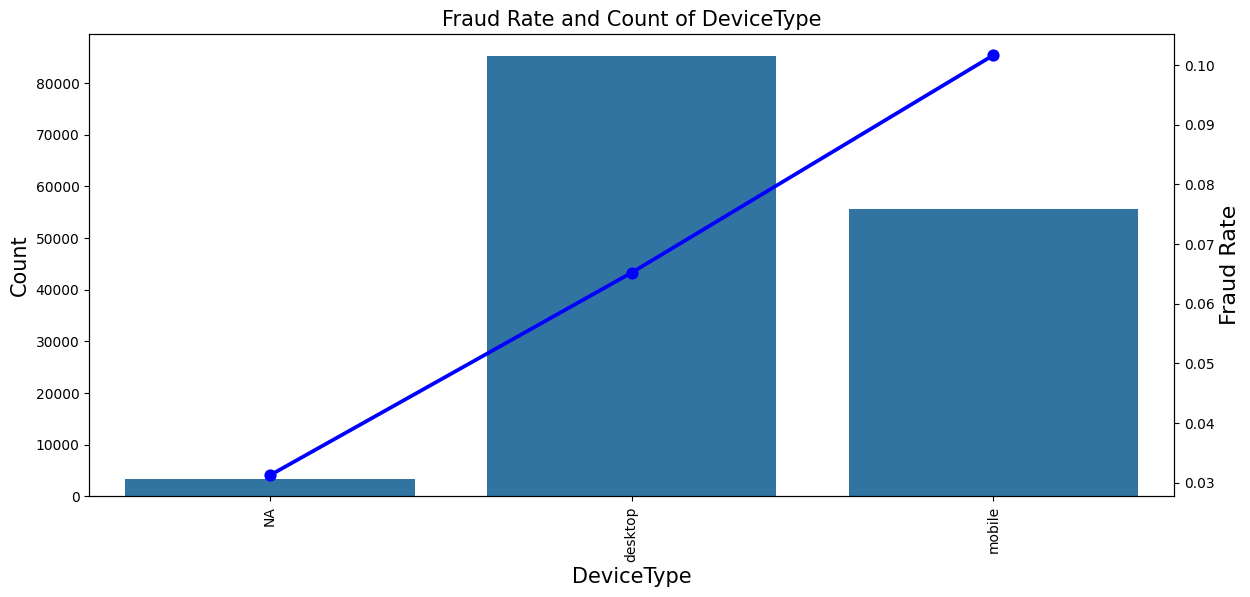

In [ ]:
cat_var_fraud_rate("DeviceType")

Mobile has much higher fraud rate than desktop

### DeviceInfo

In [ ]:
train_df.loc[:,'DeviceInfo'].value_counts()

,count
DeviceInfo,
Windows,47722
iOS Device,19782
MacOS,12573
Trident/7.0,7440
rv:11.0,1901
...,...
SAMSUNG SM-N910V Build/MMB29M,1
ANE-LX3 Build/HUAWEIANE-LX3,1
SM-N900T,1


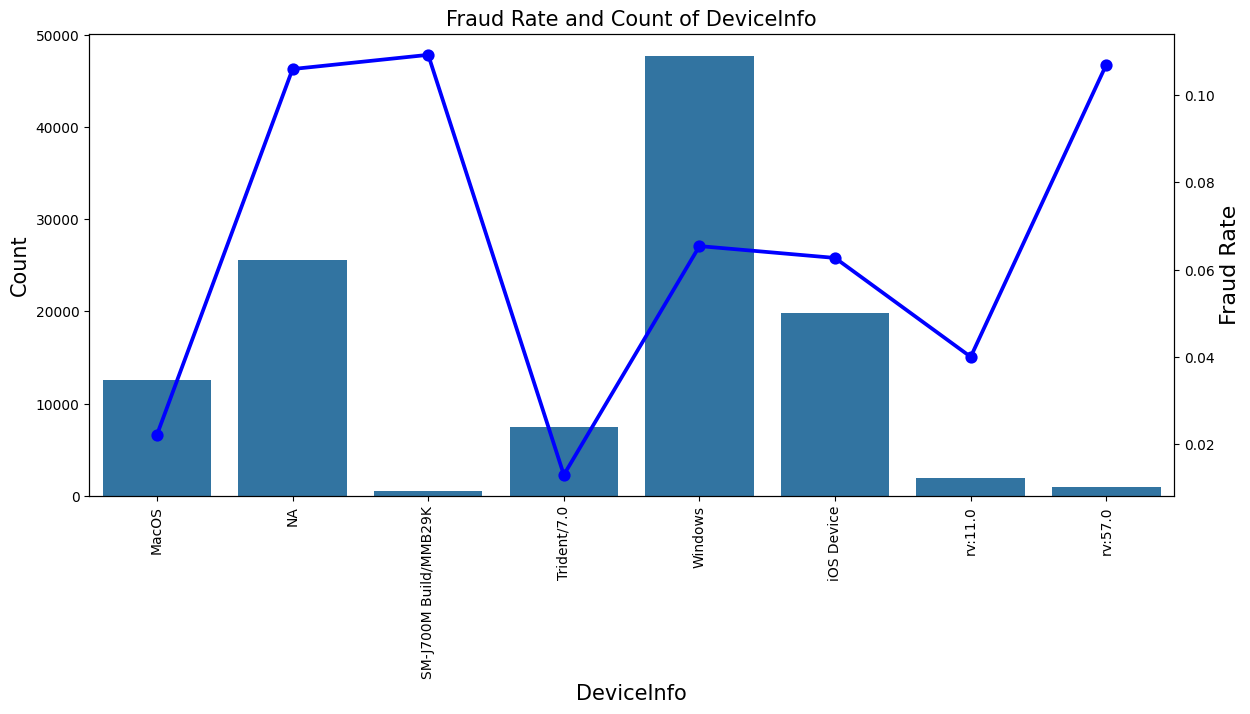

In [ ]:
device_filter = train_df.groupby("DeviceInfo").filter(lambda x: len(x) > 500)["DeviceInfo"].unique()
cat_var_fraud_rate("DeviceInfo", df = train_df[train_df["DeviceInfo"].isin(device_filter)])

In [ ]:
device_counts = train_df["DeviceInfo"].value_counts()
train_df["DeviceInfo_grouped"] = train_df["DeviceInfo"].apply(lambda x: x if device_counts[x] >= 400 else "Others")
train_df["DeviceInfo_grouped"].value_counts()

,count
DeviceInfo_grouped,
Windows,47722
Others,26866
NA,25567
iOS Device,19782
MacOS,12573
Trident/7.0,7440
rv:11.0,1901
rv:57.0,962
SM-J700M Build/MMB29K,549


As we can see, the fraud rate is high for some unique devices: "SM-A300H Build...", "rv:57.0". Windows is the most popular device used for indentified transactions, which's reasonable for its moderate fraud rate.

### Examine ID

In [ ]:
train_df.loc[:,'id_12':'id_38'].nunique()

,0
id_12,2
id_13,54
id_14,25
id_15,3
id_16,2
id_17,104
id_19,522
id_20,394
id_28,2
id_29,2


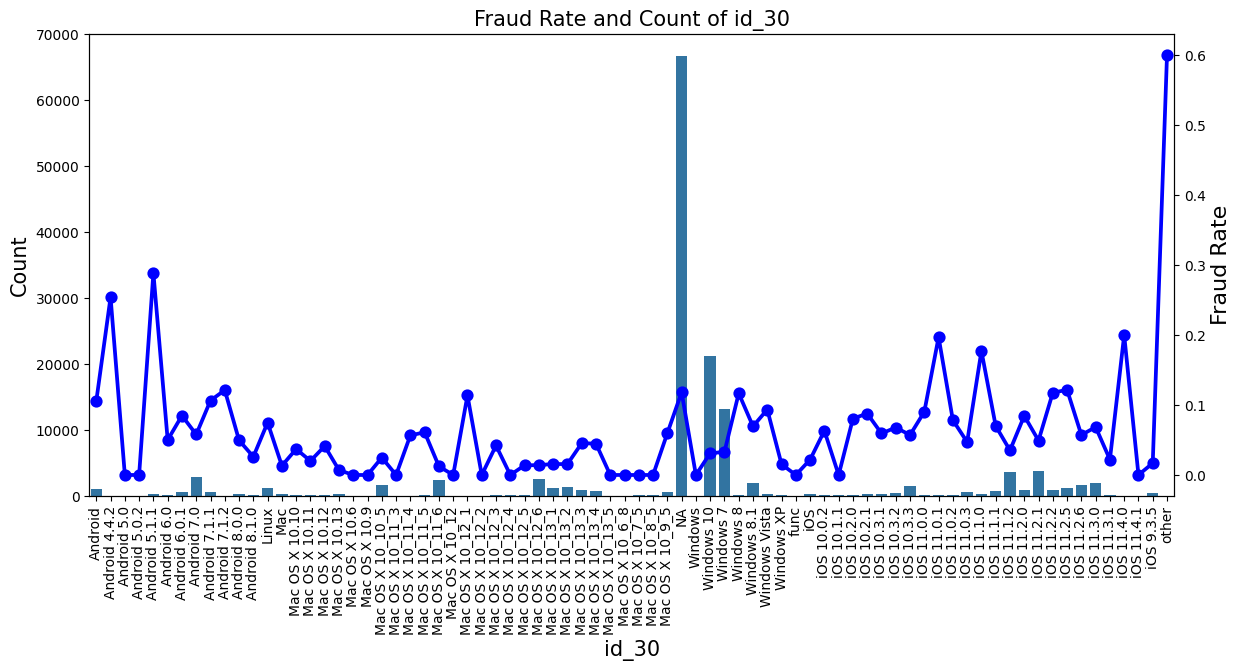

In [ ]:
cat_var_fraud_rate("id_30")

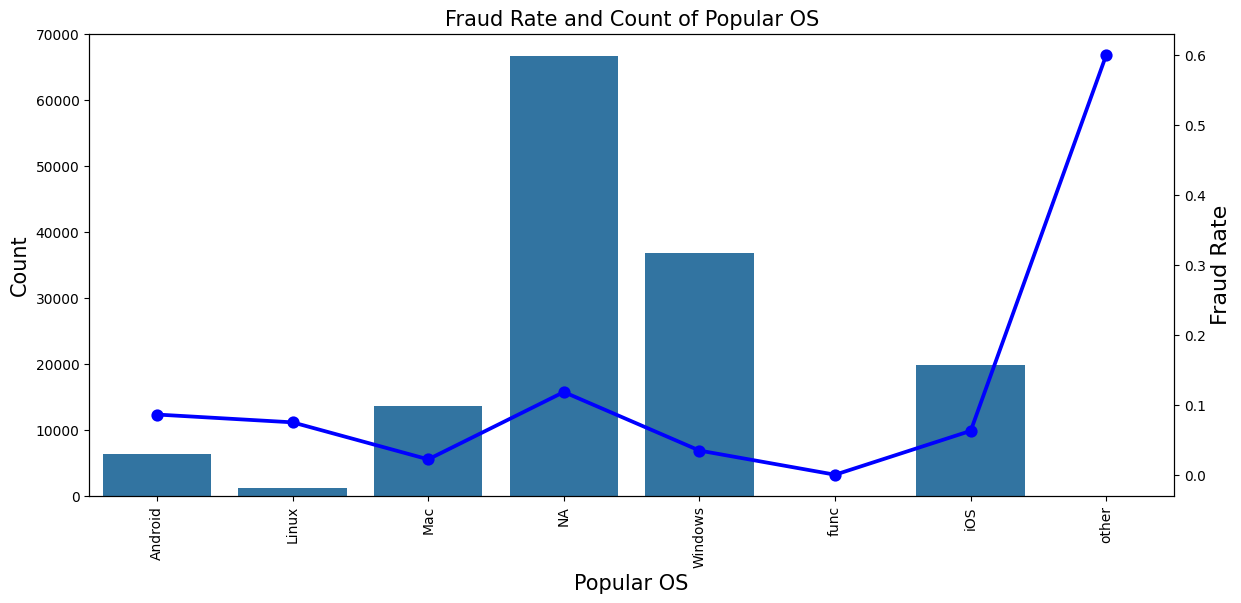

In [ ]:
train_df["Popular OS"] = train_df["id_30"].str.split(' ', expand = True)[[0]]
cat_var_fraud_rate("Popular OS")

Curious about the number of instances for Android vs iOS

In [ ]:
os_count = train_df["Popular OS"].value_counts()
train_df["Popular OS_grouped"] = train_df["Popular OS"].apply(lambda x: x if os_count[x] >= 1000 else "Others")
train_df["Popular OS_grouped"].value_counts()

,count
Popular OS_grouped,
NA,66668
Windows,36739
iOS,19782
Mac,13580
Android,6303
Linux,1136
Others,25


### Browser

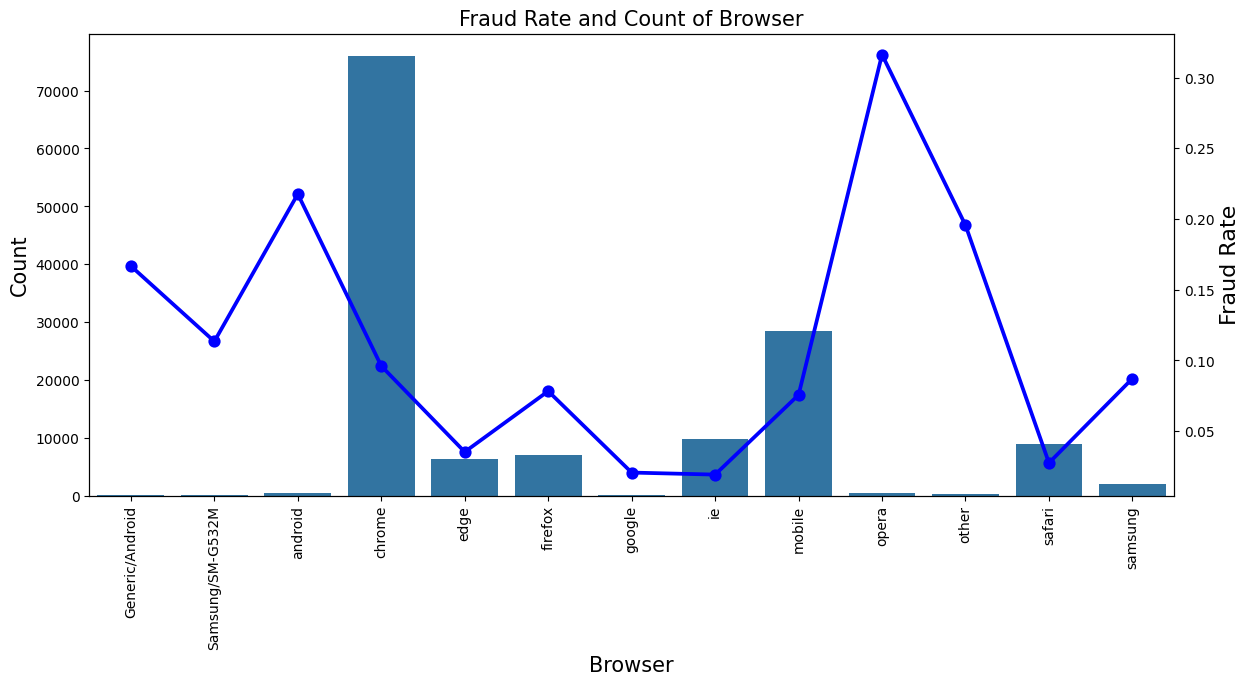

In [ ]:
train_df["Browser"] = train_df["id_31"].str.split(' ', expand = True)[[0]]
browser_filter = train_df.groupby("Browser").filter(lambda x: len(x) > 100)["Browser"].unique()
cat_var_fraud_rate("Browser", df = train_df[train_df["Browser"].isin(browser_filter)])

Opera and Android has high fraud rate (although small amount of instances)

In [ ]:
browser_counts = train_df["Browser"].value_counts()
train_df["Browser_grouped"] = train_df["Browser"].apply(lambda x: x if browser_counts[x] > 320 else "Others")
train_df["Browser_grouped"].value_counts()

,count
Browser_grouped,
chrome,76059
mobile,28379
ie,9733
safari,8913
firefox,7012
edge,6401
NA,3951
samsung,2044
Others,906


**The number of decimal places in transaction amount**

Some of the transaction amounts have three decimal places to the right of the decimal point, which is quite rare in common transactions where there are usally 2 decimal places at max. This might be due to the foreign transactions in which the currency exchange rates normally contain more than 2 decimal places, or it could be a suspicious transaction that is worth checking.

In [ ]:
def num_var_viz(col, df = train_df):
  plt.figure(figsize=(20,10))
  plt.suptitle('{}'.format(col), fontsize=18)

  plt.subplot(131)
  sns.distplot(df[col], kde= False)
  plt.title('{} Distribution'.format(col), fontsize = 15)

  plt.subplot(132)
  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
  sns.distplot(df[df['isFraud'] == 1][col], color = 'orange', kde= False , label = 'Fraud')
  plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
  plt.legend()

  plt.subplot(133)
  sns.boxplot(x = "isFraud", y = col, data = df)
  plt.title('{} Boxplot'.format(col), fontsize = 15)

<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

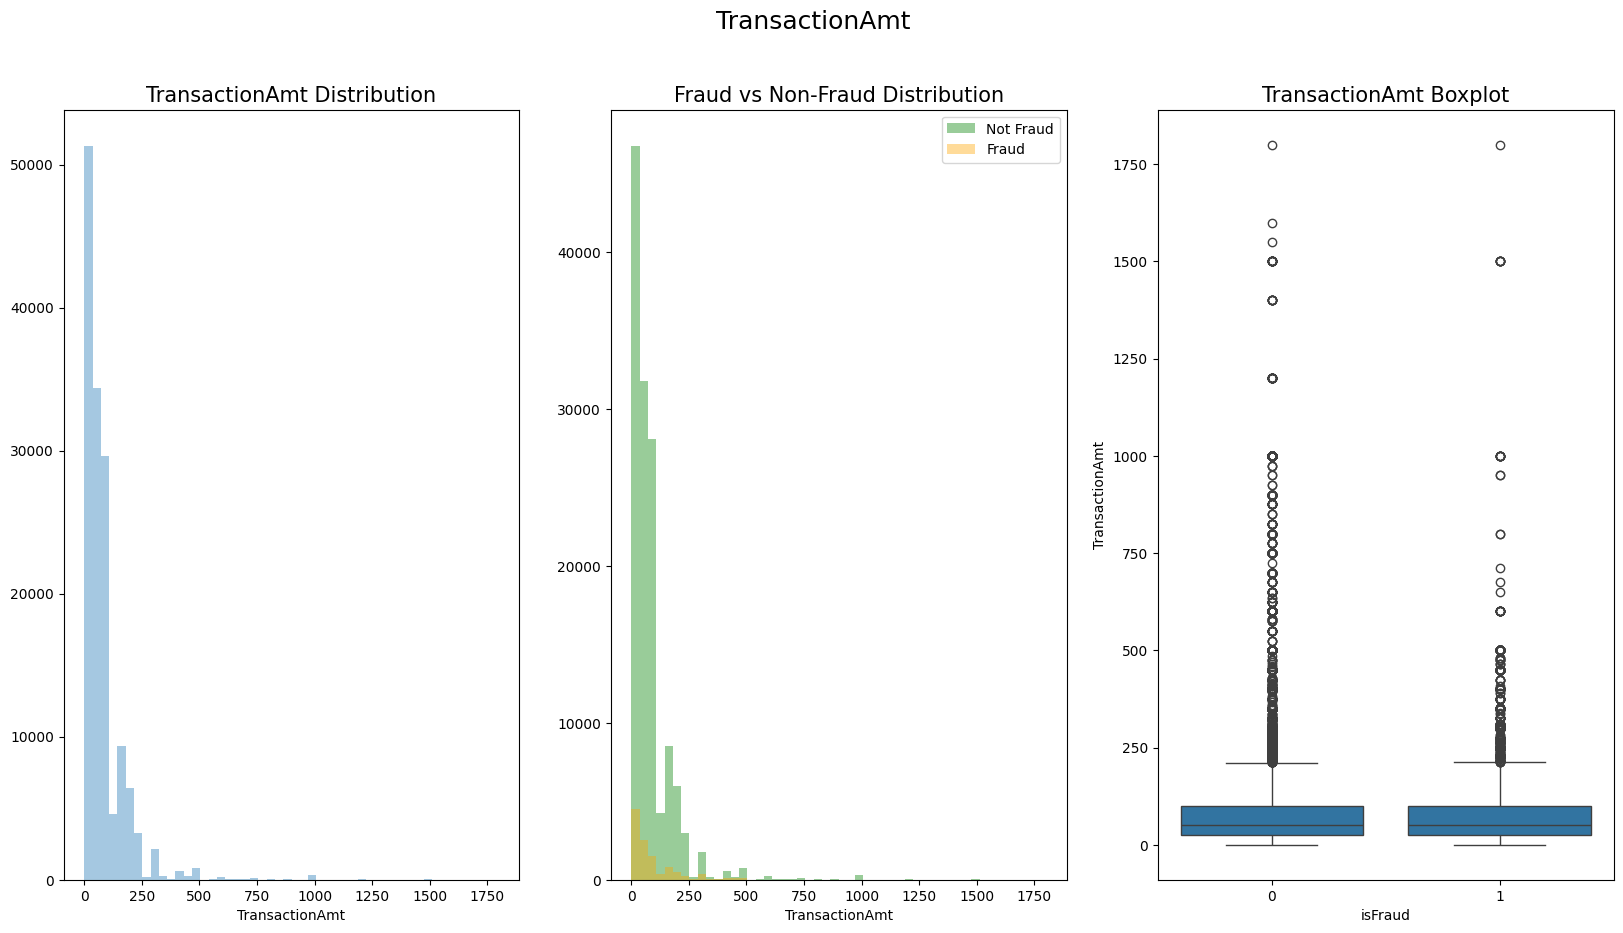

In [ ]:
num_var_viz("TransactionAmt")

- Right-skewed: the majority of transactions are small
- Only little difference between Fraud and non-fraud

In [ ]:
def change(amt):
    num = 0
    while((int(amt)*10 != int(amt*10)) and (num < 3)):
        num = num + 1
        amt = amt * 10
    return num

train_new["TransactionAmt_decimal"] = train_new["TransactionAmt"].map(change)
print(train_new.head(n=20))

    isFraud  TransactionAmt ProductCD  card1  card2  card3       card4  card5  \
0         0         68.5000         W  13926    NaN  150.0    discover  142.0   
1         0         29.0000         W   2755  404.0  150.0  mastercard  102.0   
2         0         59.0000         W   4663  490.0  150.0        visa  166.0   
3         0         50.0000         W  18132  567.0  150.0  mastercard  117.0   
4         0         50.0000         H   4497  514.0  150.0  mastercard  102.0   
5         0         49.0000         W   5937  555.0  150.0        visa  226.0   
6         0        159.0000         W  12308  360.0  150.0        visa  166.0   
7         0        422.5000         W  12695  490.0  150.0        visa  226.0   
8         0         15.0000         H   2803  100.0  150.0        visa  226.0   
9         0        117.0000         W  17399  111.0  150.0  mastercard  224.0   
10        0         75.8750         C  16496  352.0  117.0  mastercard  134.0   
11        0         16.5000 

<ipython-input-28-103aa4f85fdf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["TransactionAmt_decimal"] = train_new["TransactionAmt"].map(change)


In [ ]:
df1 = train_new.groupby("TransactionAmt_decimal").count()["isFraud"]
df1.head()

,isFraud
TransactionAmt_decimal,
0,362115
1,31417
2,9263
3,187745


In [ ]:
df1 = train_new[train_new['isFraud'] == 1]
df1.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,TransactionAmt_decimal
203,1,445.00000,W,18268,583.0,150.0,visa,226.0,credit,NaN,...,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,0
240,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
243,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
245,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
288,1,155.50000,C,16578,545.0,185.0,visa,226.0,credit,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1


In [ ]:
df1 = train_new[train_new['isFraud'] == 1]
d1 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df1.groupby("TransactionAmt_decimal").count()["isFraud"])}
df1 = pd.DataFrame(data=d1)
df1

,Decimal,Count
0,0,12341
1,1,1101
2,2,804
3,3+,6417


In [ ]:
df0 = train_new[train_new['isFraud'] == 0]
d0 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df0.groupby("TransactionAmt_decimal").count()["isFraud"])}
df0 = pd.DataFrame(data=d0)
df0

,Decimal,Count
0,0,349774
1,1,30316
2,2,8459
3,3+,181328


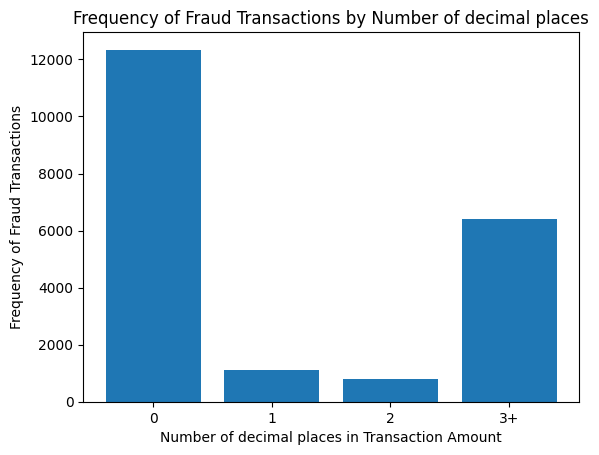

In [ ]:
plt.bar(df1['Decimal'], df1['Count'])
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Frequency of Fraud Transactions")
plt.title("Frequency of Fraud Transactions by Number of decimal places")
plt.show()

In [ ]:
d = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
df = pd.DataFrame(data=d)
df

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
dN = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(1-train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
dfN = pd.DataFrame(data=dN)
dfN

In [ ]:
plt.bar(df['Decimal'], df['Prob'], color = 'maroon')
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Probability of Comitting Fraud")
plt.title("Probability of Committing Fraud by Number of decimal places")
plt.show()

- If you drop your card, it's likely the person who found it by chance and commit a fraud would spend it on consumable and essential products like grocery and gas. The perp will likely go somewhere nearby and spend a larger amount than usual before the card get locked. So perhaps we should look at user's purchase history so that any activities or purchases that deviate from normal buying habit would stand out. But we don't have identifiable data, so we can't go on this route.
A fascinating insight of this dataset is that there might be a relationship between the decimal places of the transaction amount and whether that transaction is fraudulent. In order to simplify and avoid bias, transactions with more than three decimal places will also be counted as three decimal places since they scarcely happen and might affect the overall model if it is too specific (the longest decimal is 30). According to the graphs above, those with three decimal places in transactions are three times more likely to commit fraud than those with only none and one decimal place in transactions. It is infrequent to have standard transactions and online payments to have over two decimal places in their value. Therefore, the intuition to have three or more decimal places in their transactions is suspicious, except for foreign exchange circumstances. In conclusion, the number of decimal places is also vital to include in our fraud detection model.

In [ ]:
train_transaction.iloc[:,30:39].isnull().sum(axis = 0)

In [ ]:
train_transaction.card4.value_counts()

**c. Distance between sellers and buyers**

Another variable that is worth investigating is the distance between the purchaser and the receiver. Note that the outliers are removed from the plot because the variable ranged widely, so that it shrinks the boxplot into thick lines. According to the boxplots, the fraudulent transactions are located much further than normal transactions, which also emphasizes the result that transactions from foreign email domains have a higher probability of committing fraud. As a result, the distance from the purchaser to the recipient is essential to the predictive model.

In [ ]:
fraud1 = train_new[train_new['isFraud'] == 1]
fraud1 = fraud1.dropna()
fraud0 = train_new[train_new['isFraud'] == 0]
fraud0 = fraud0.dropna()
distance = [fraud1['dist1'], fraud0['dist1']]
#print(distance)

In [ ]:
train_transaction.groupby(train_transaction["isFraud"]).dist1.describe() #boxplot

In [ ]:
box = plt.boxplot(distance, showfliers=False, vert=False, widths=0.6, labels=['Fraud', 'Non-fraud'], patch_artist=True, medianprops=dict(color='black'))

colors = ['tab:orange', 'tab:blue']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Boxplot of Distance between Billing Adress by Fraud Transaction')
plt.xlabel('Distance between Billing Adress')
# show plot
plt.show()

### C-features:

In [ ]:
train_df.filter(regex = 'C').info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ProductCD  144233 non-null  object 
 1   C1         144233 non-null  float16
 2   C2         144233 non-null  float16
 3   C3         144233 non-null  float16
 4   C4         144233 non-null  float16
 5   C5         144233 non-null  float16
 6   C6         144233 non-null  float16
 7   C7         144233 non-null  float16
 8   C8         144233 non-null  float16
 9   C9         144233 non-null  float16
 10  C10        144233 non-null  float16
 11  C11        144233 non-null  float16
 12  C12        144233 non-null  float16
 13  C13        144233 non-null  float16
 14  C14        144233 non-null  float16
dtypes: float16(14), object(1)
memory usage: 5.0+ MB


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


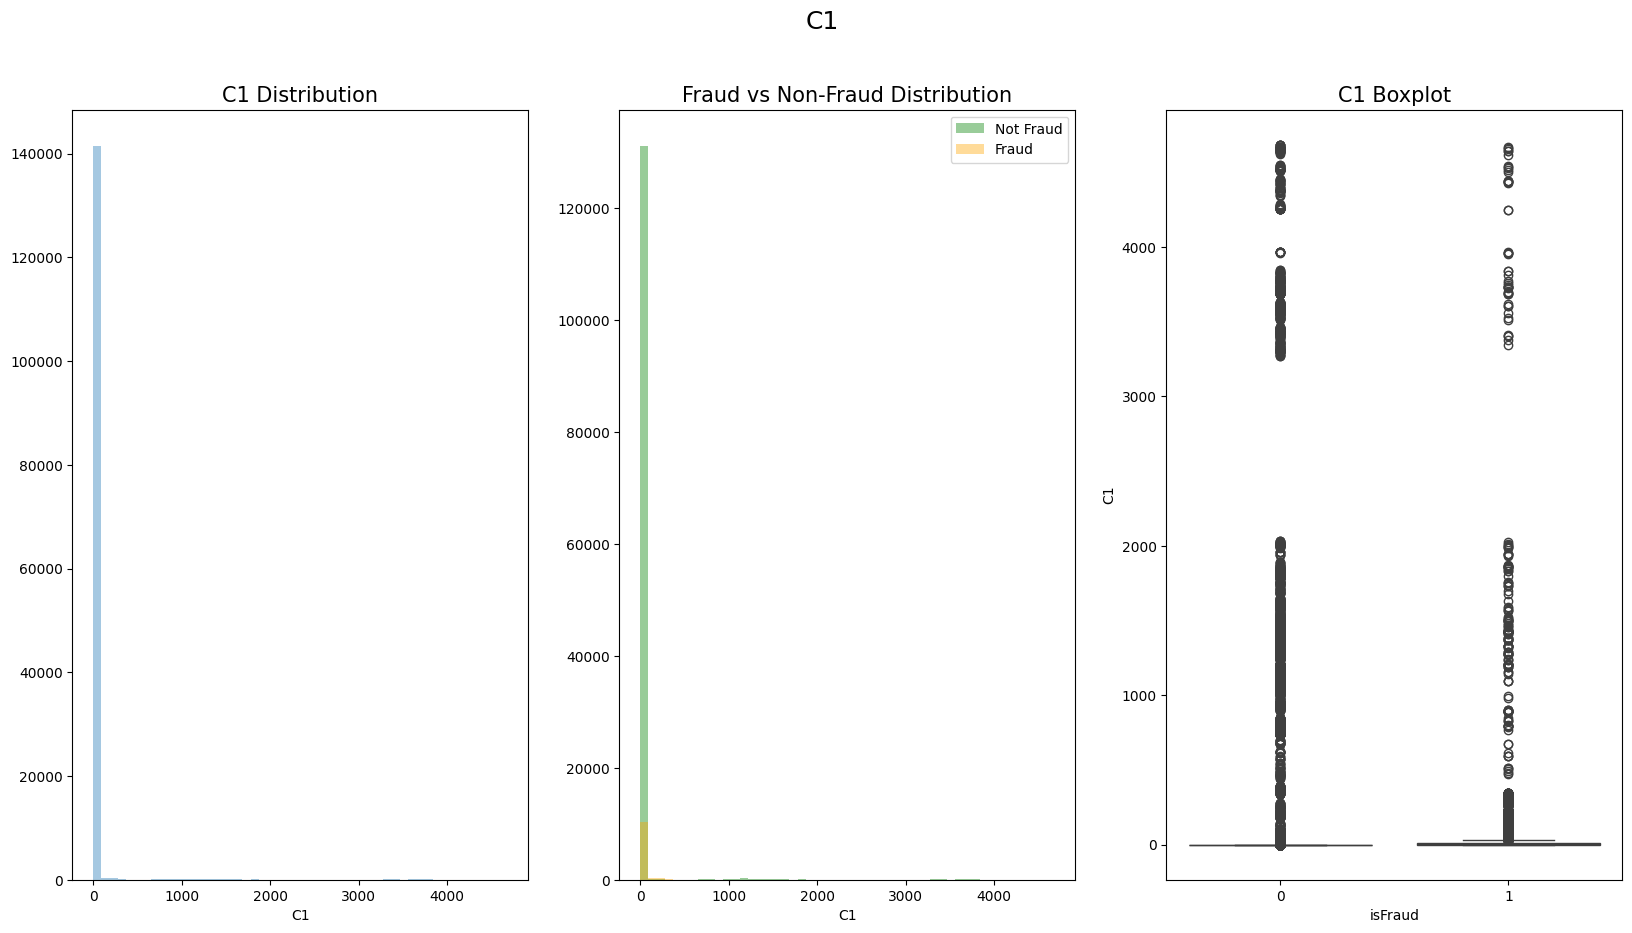

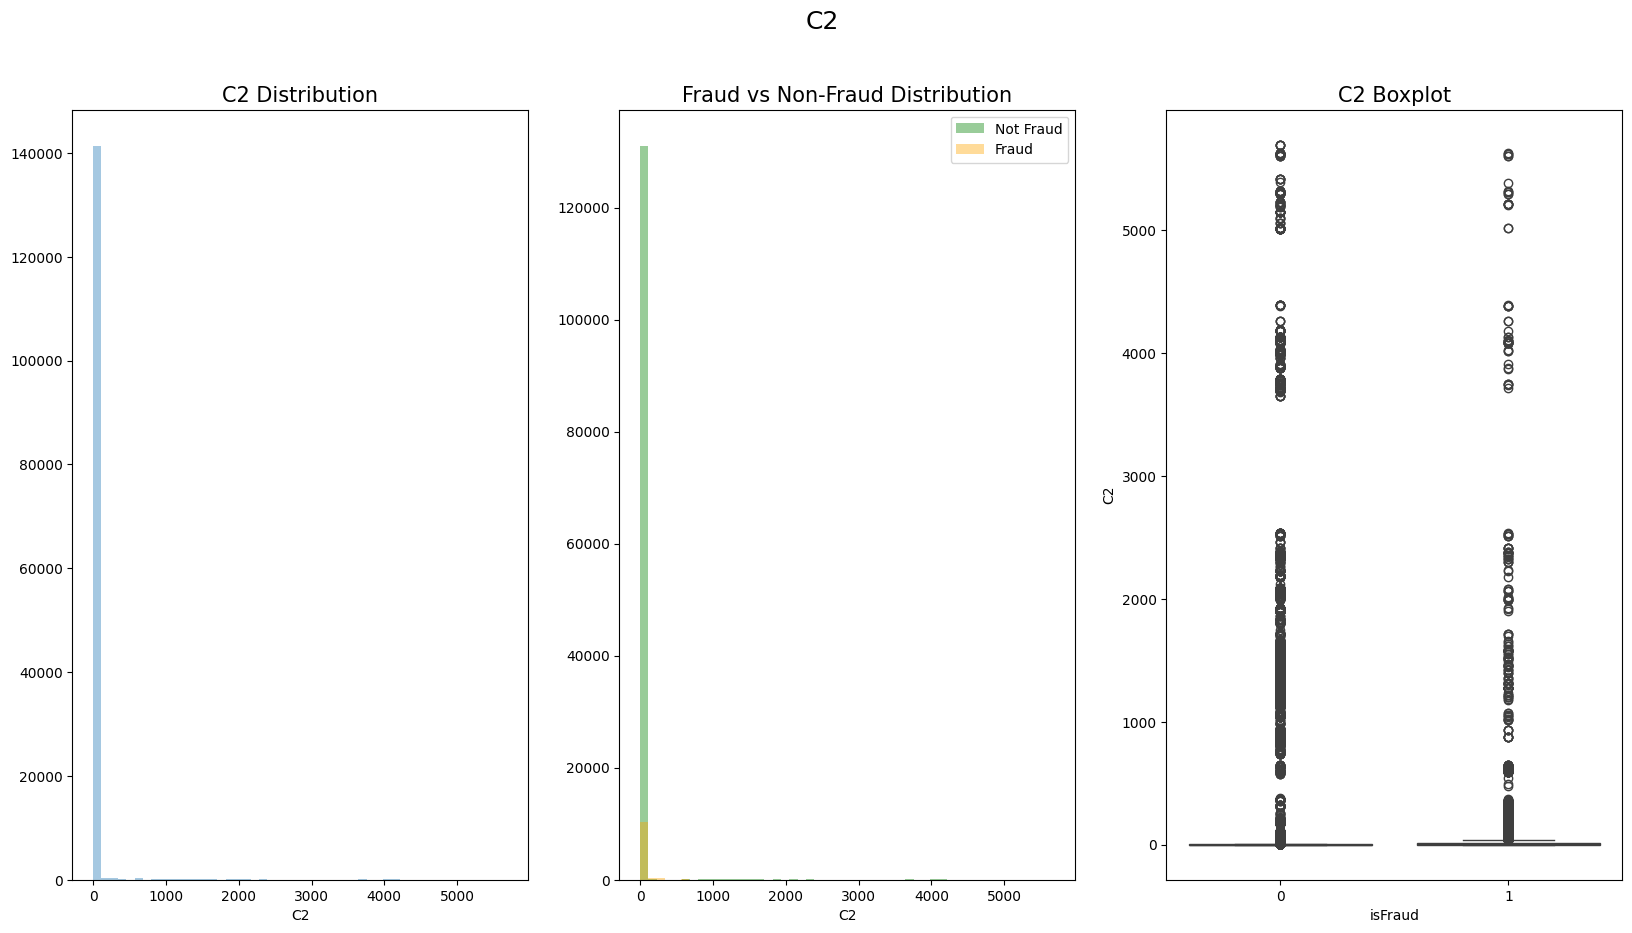

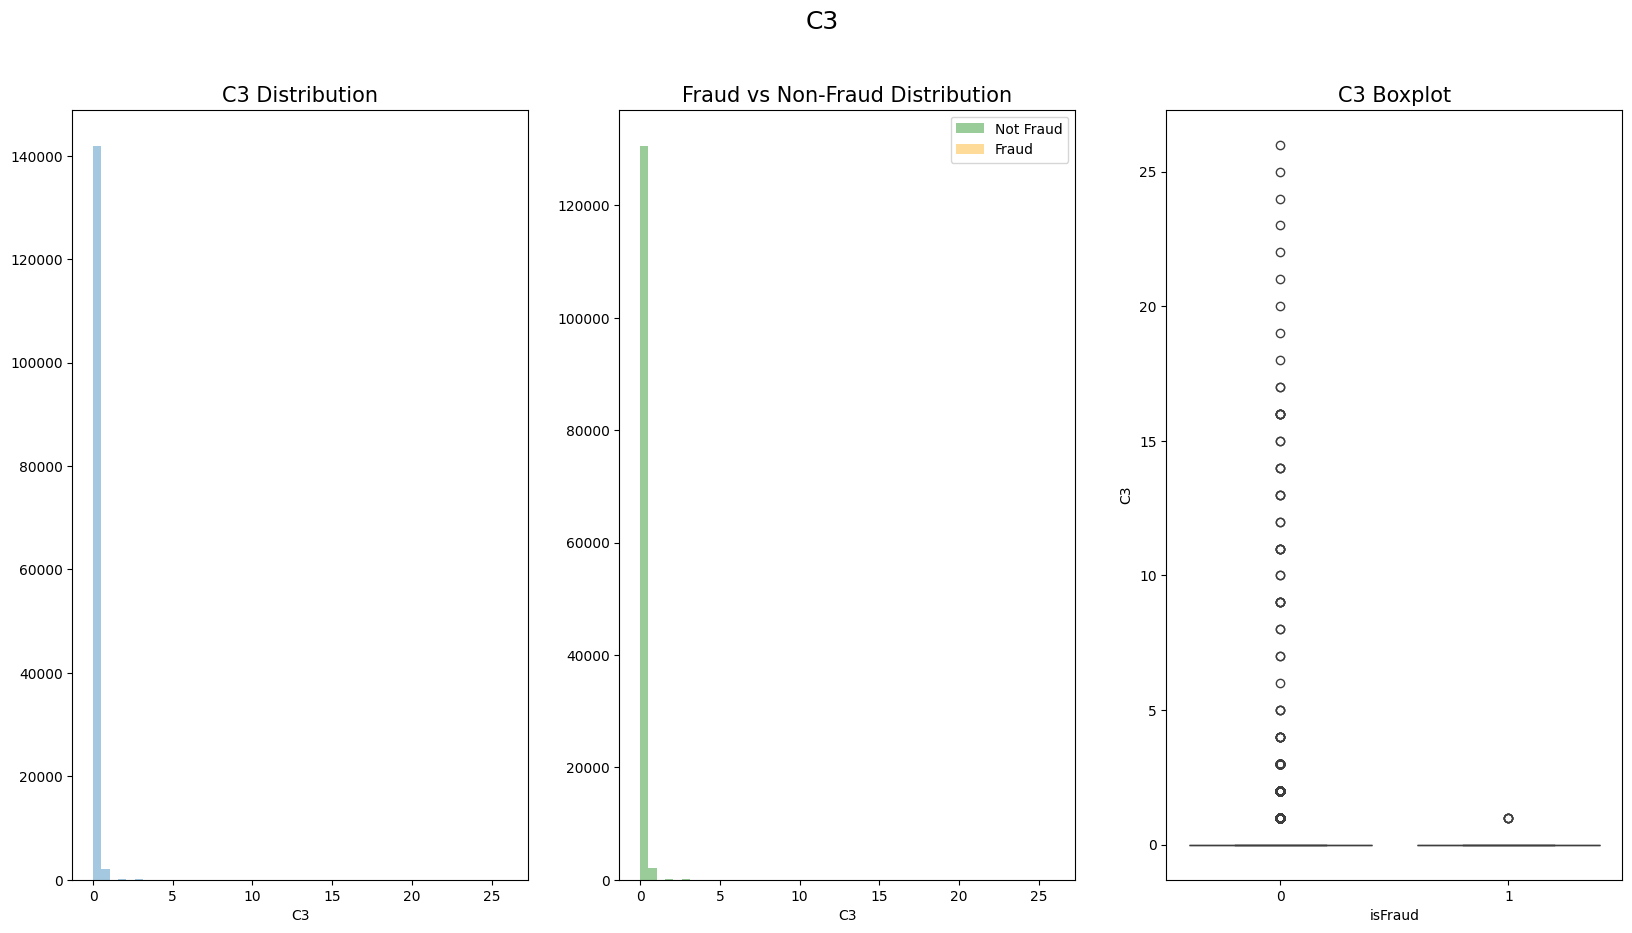

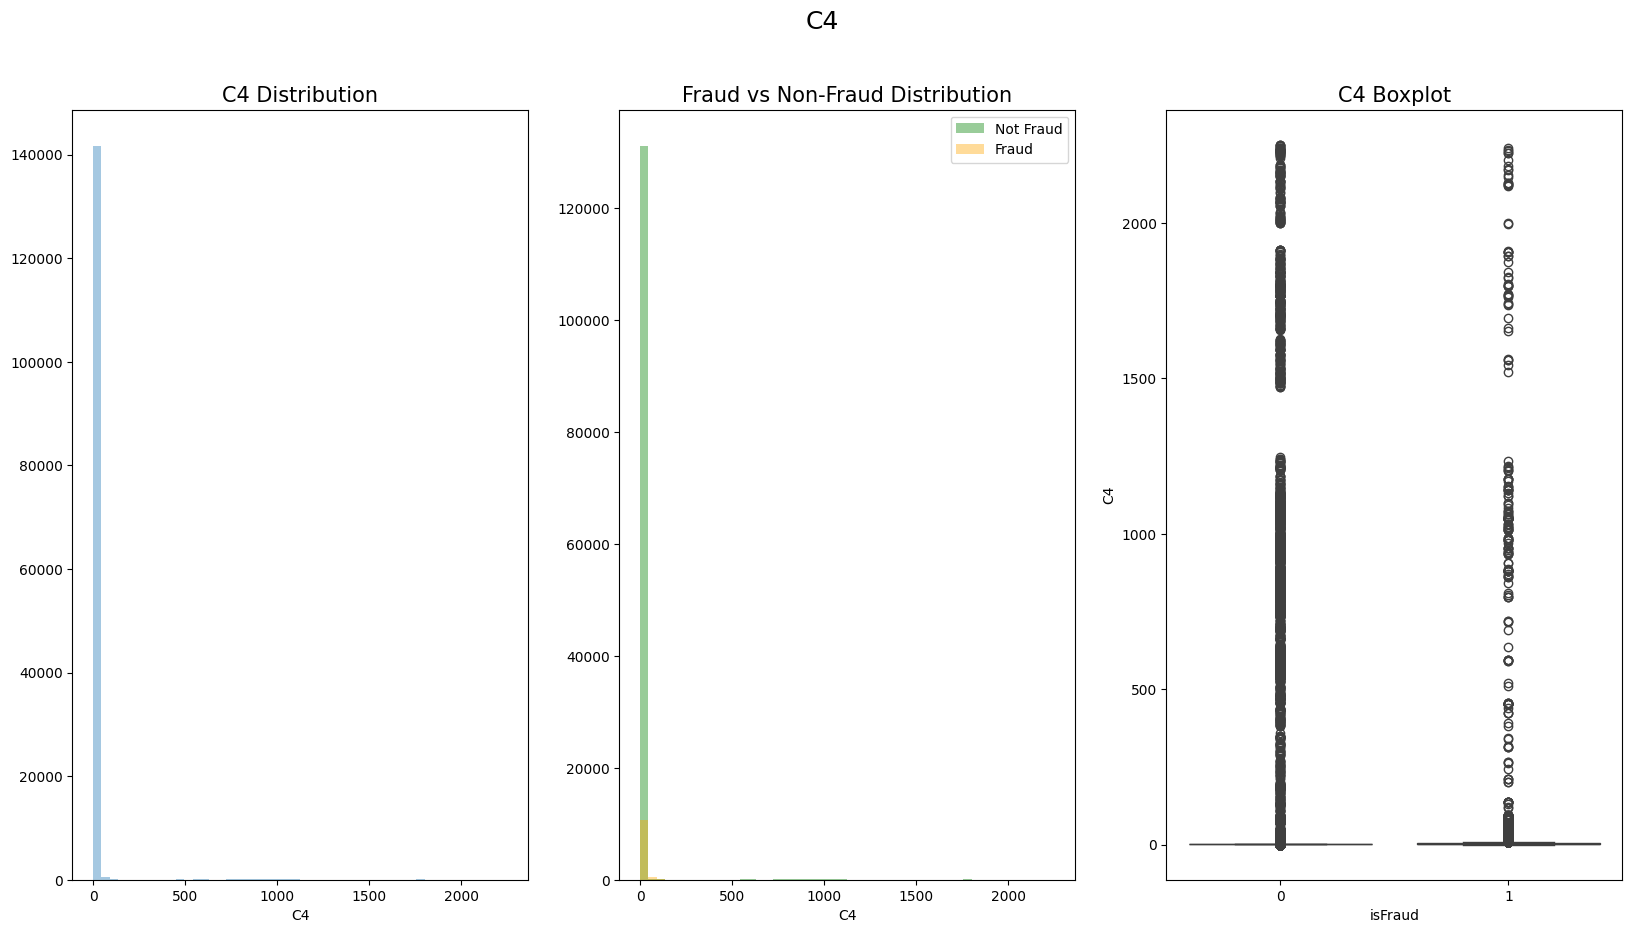

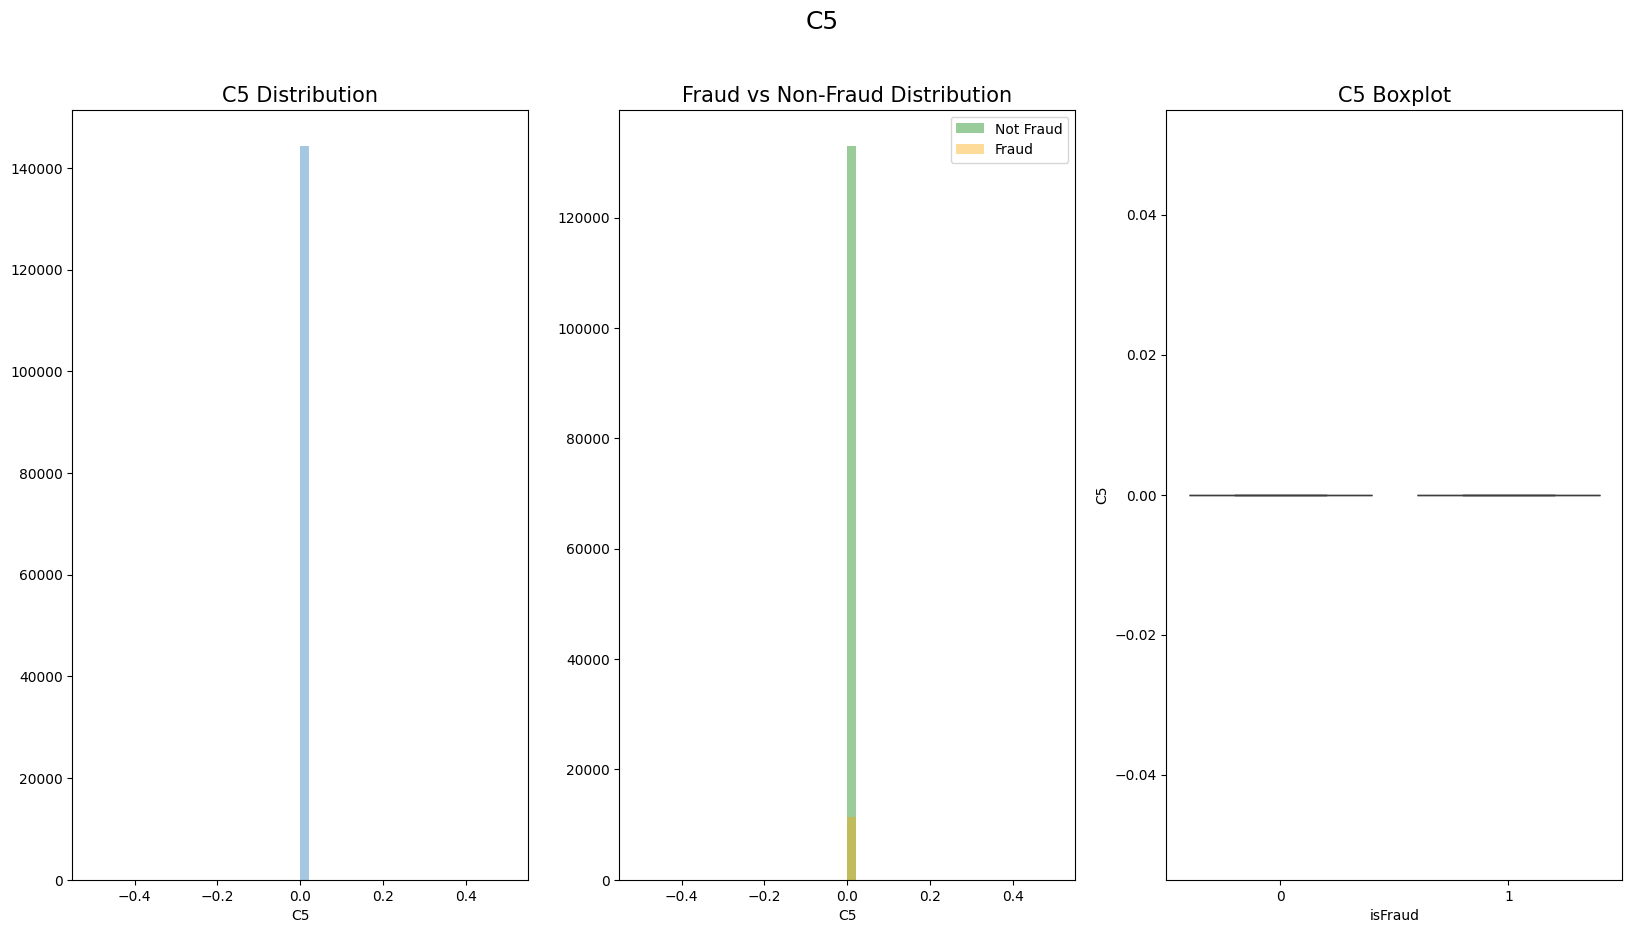

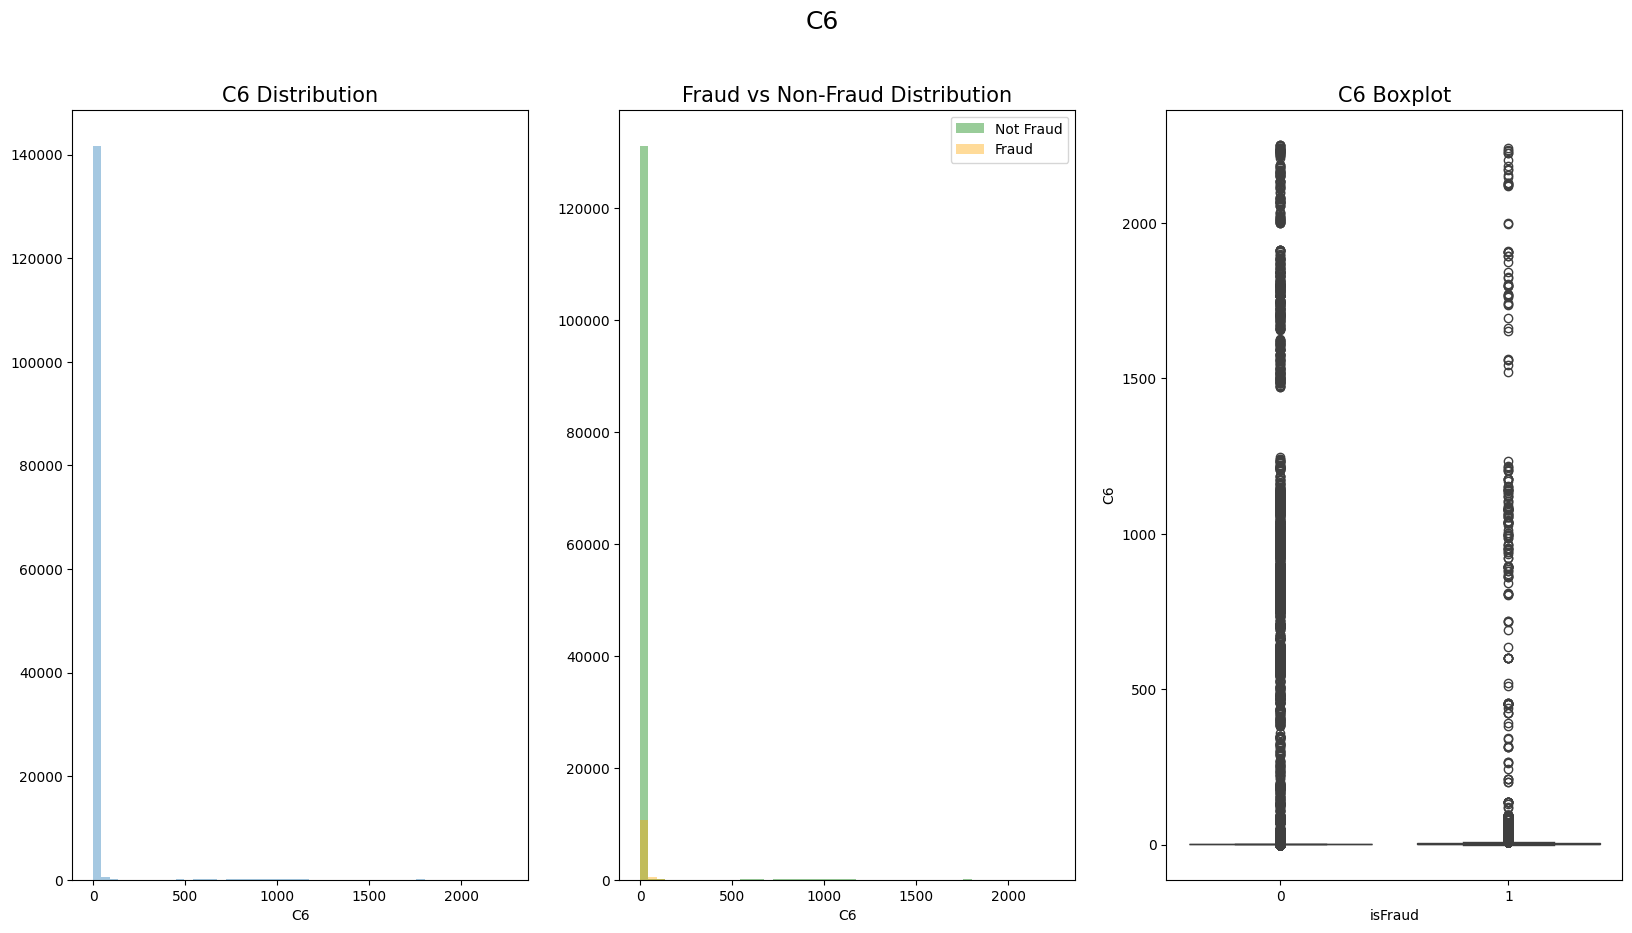

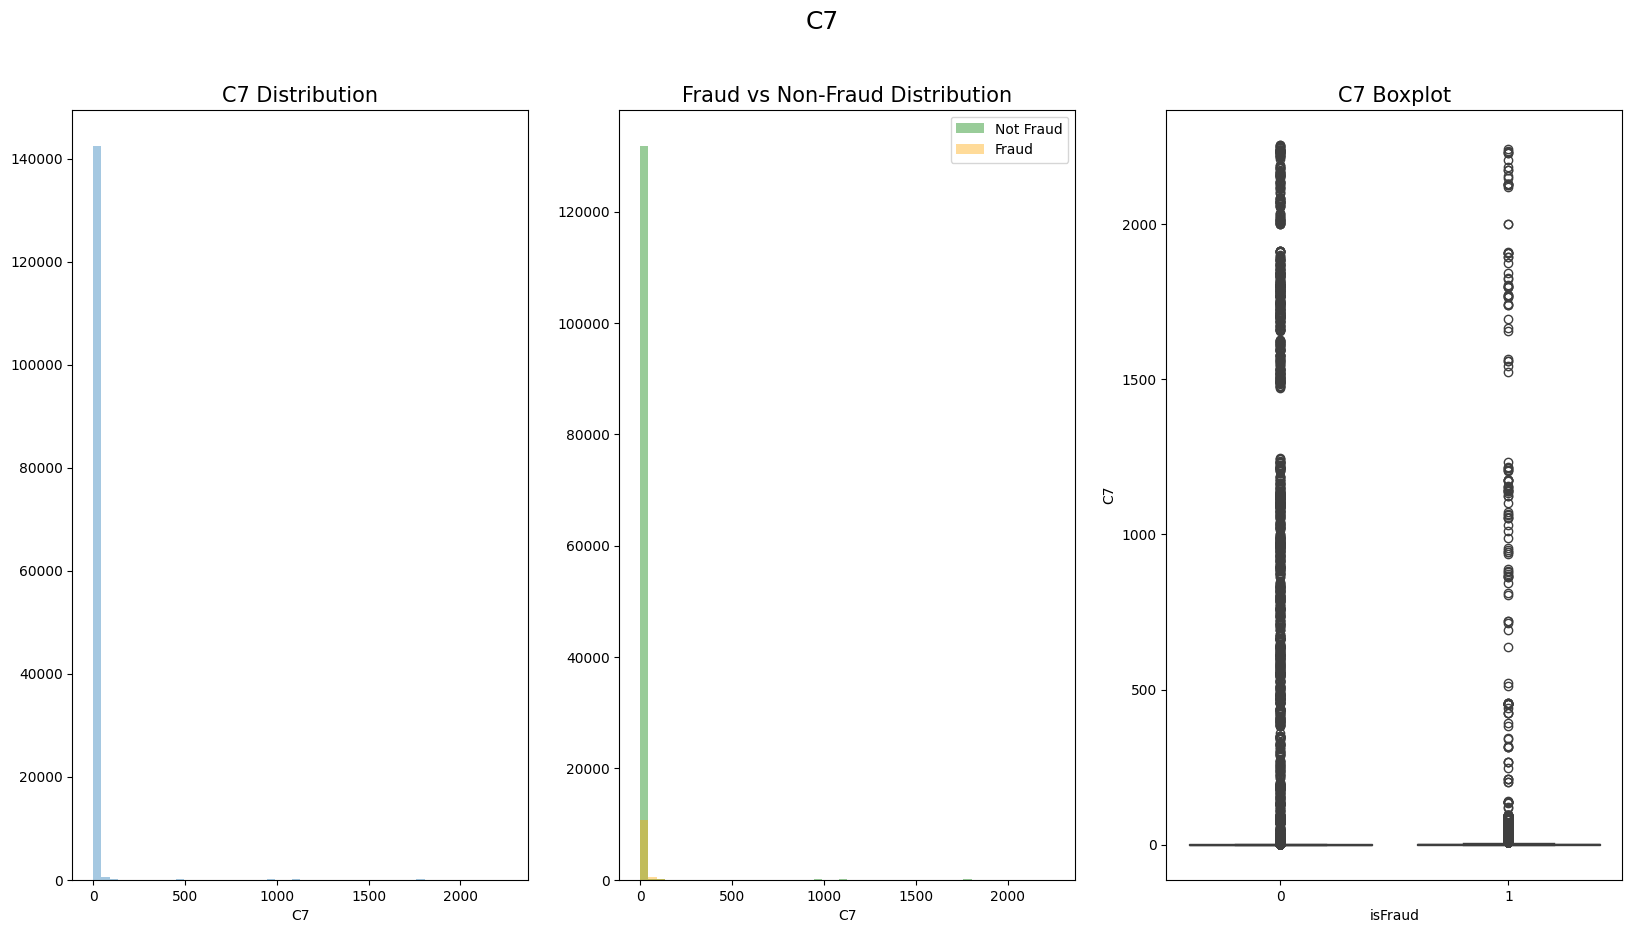

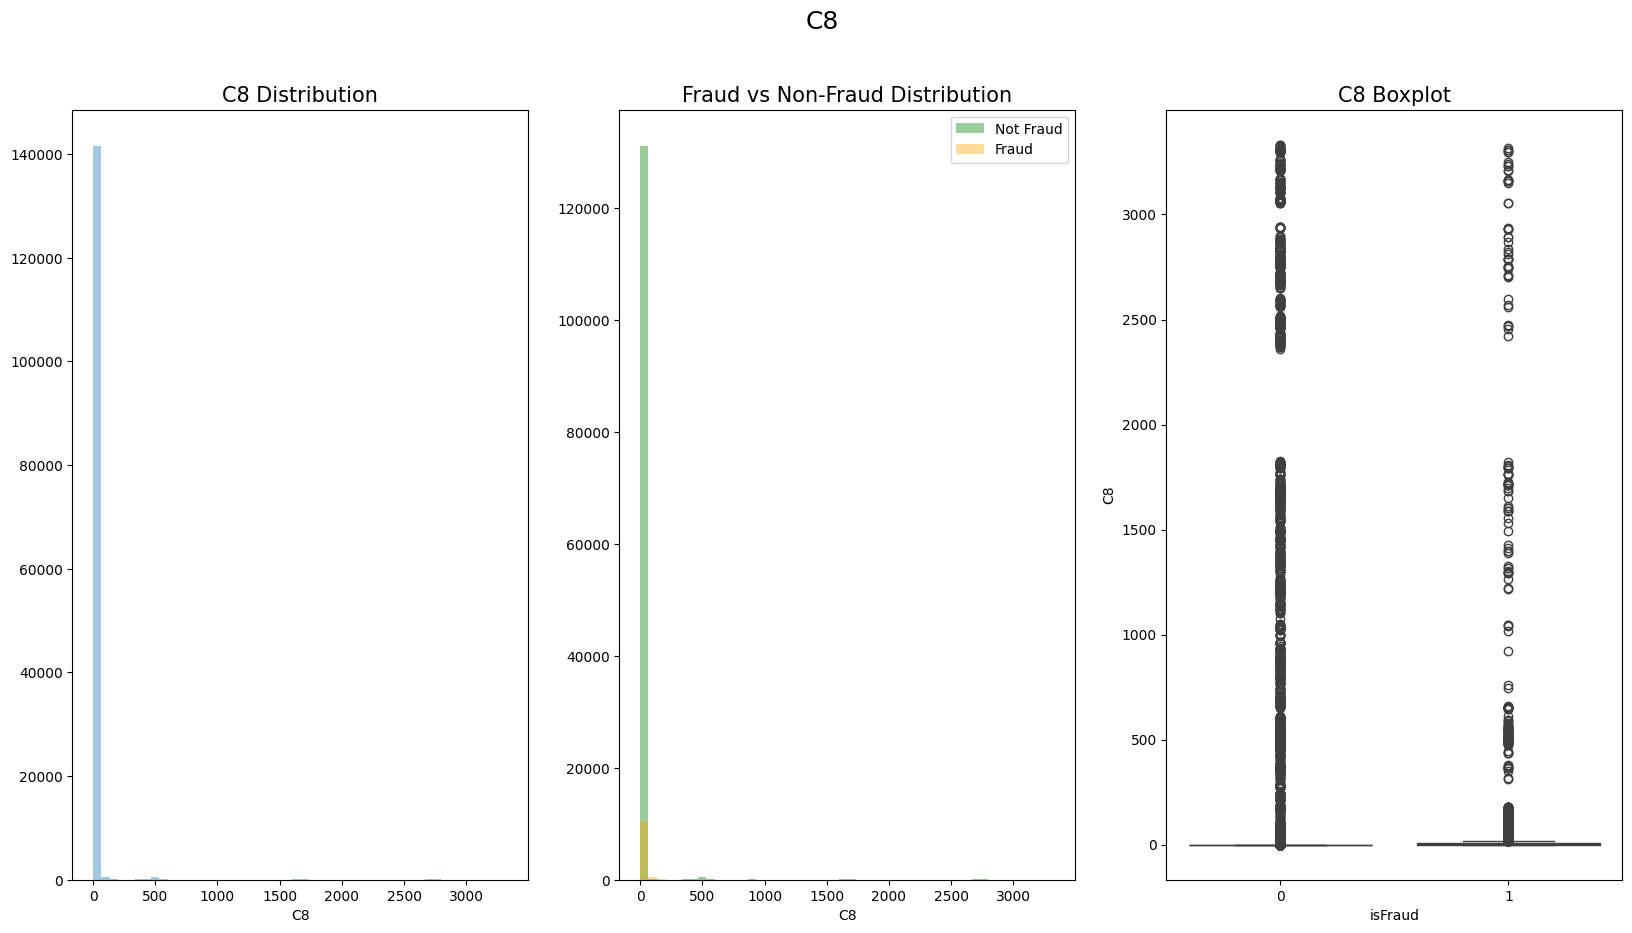

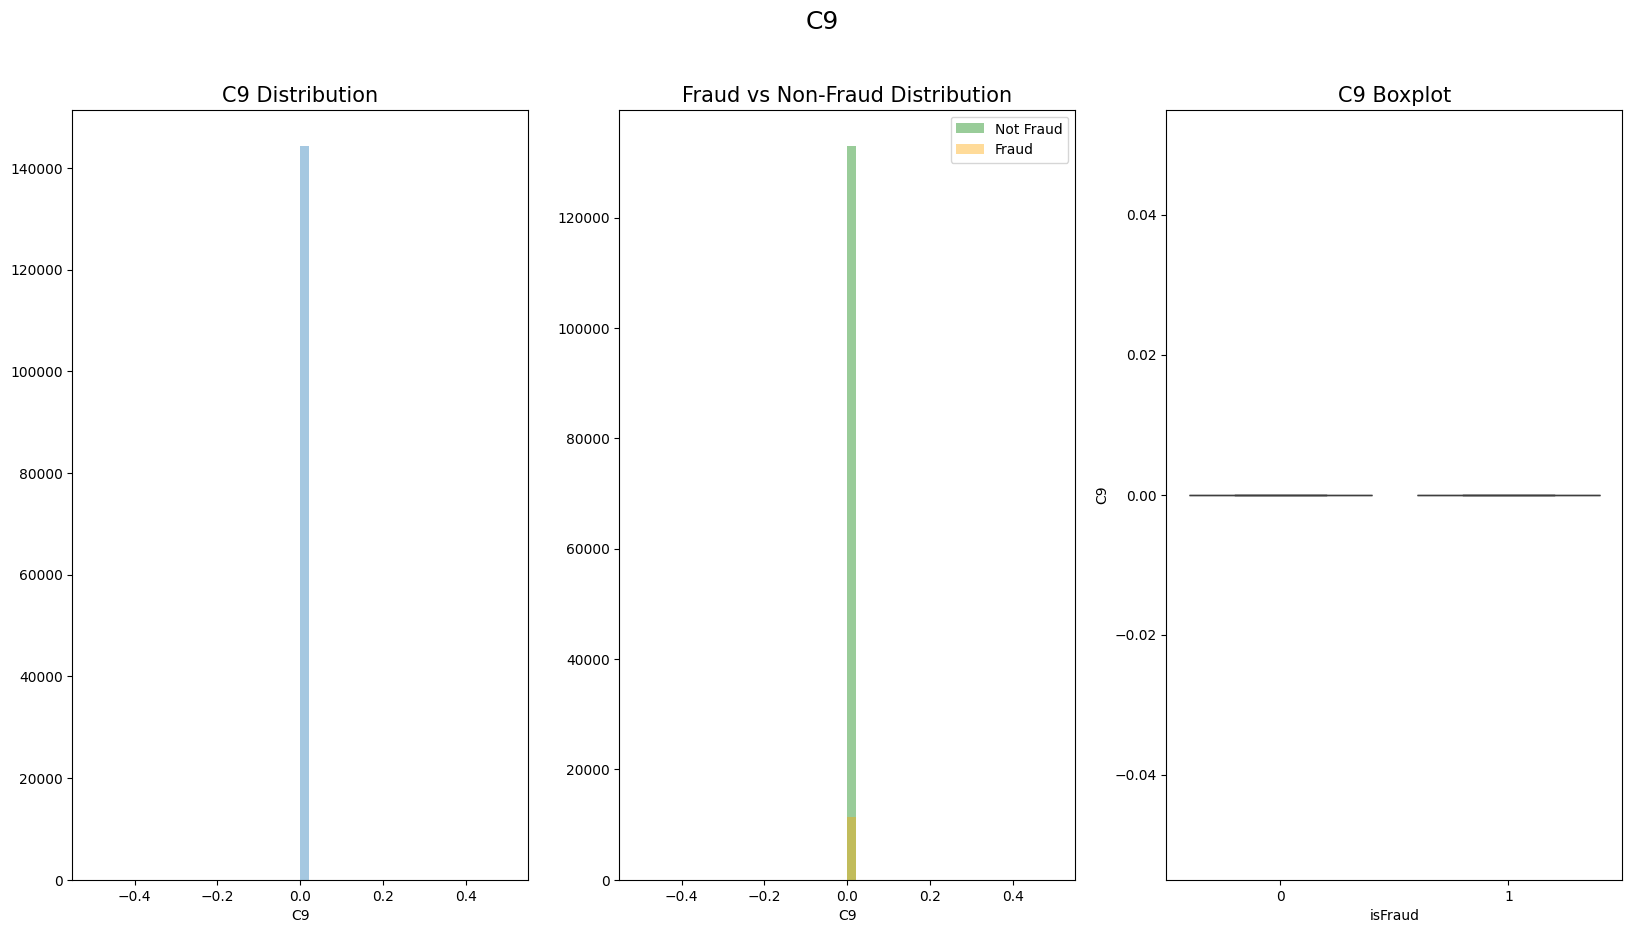

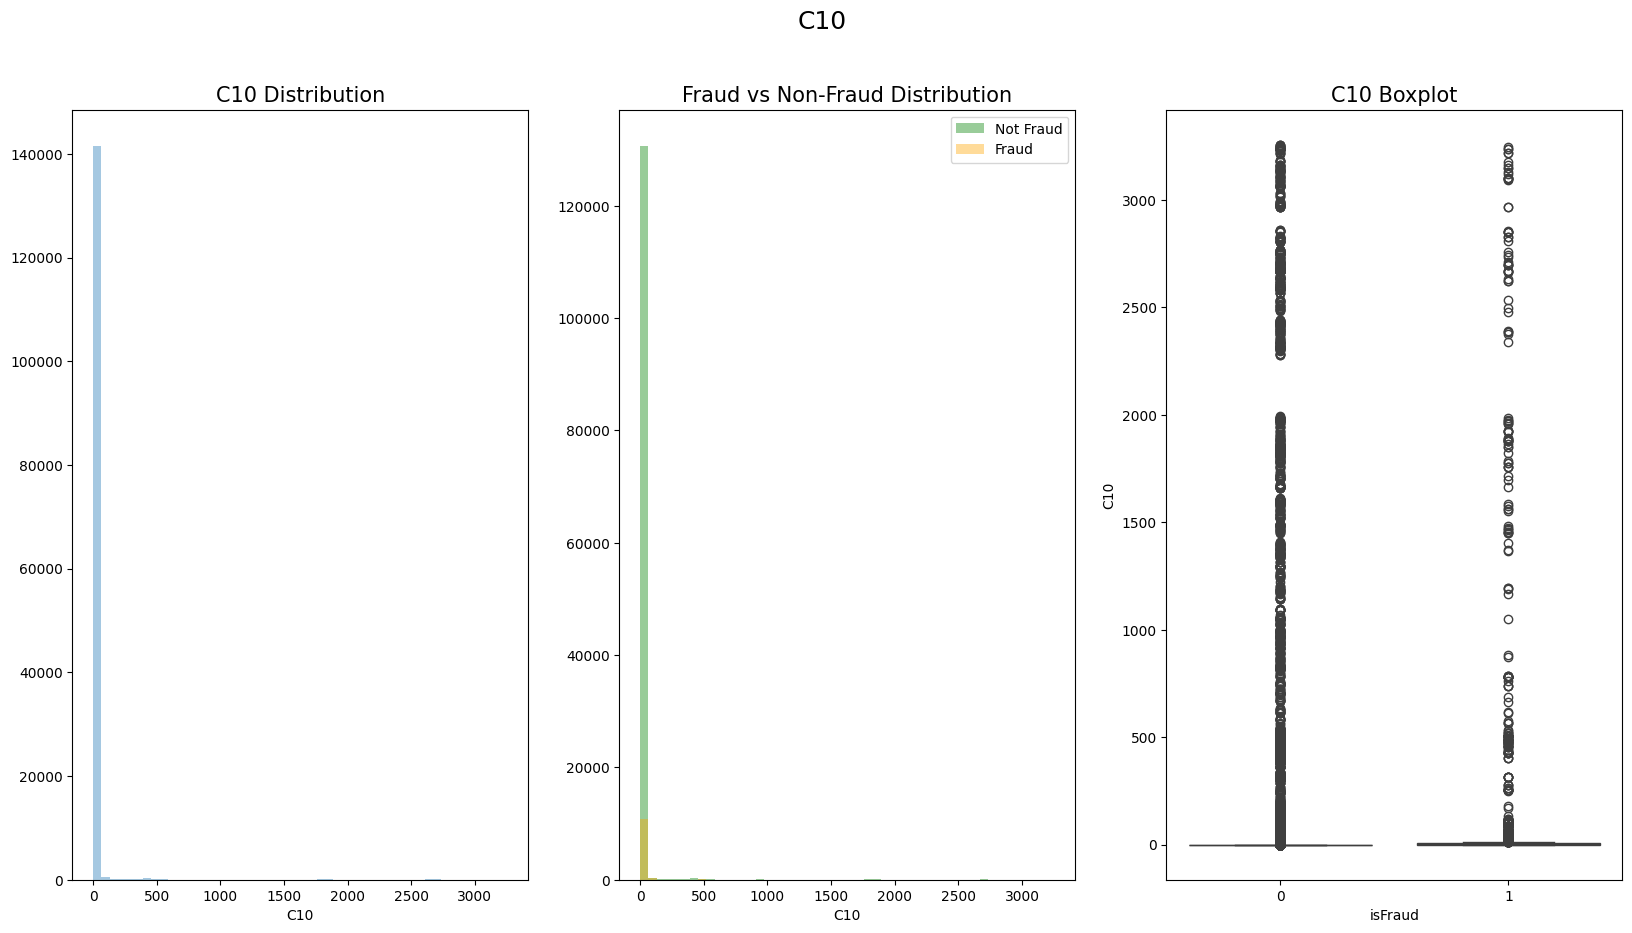

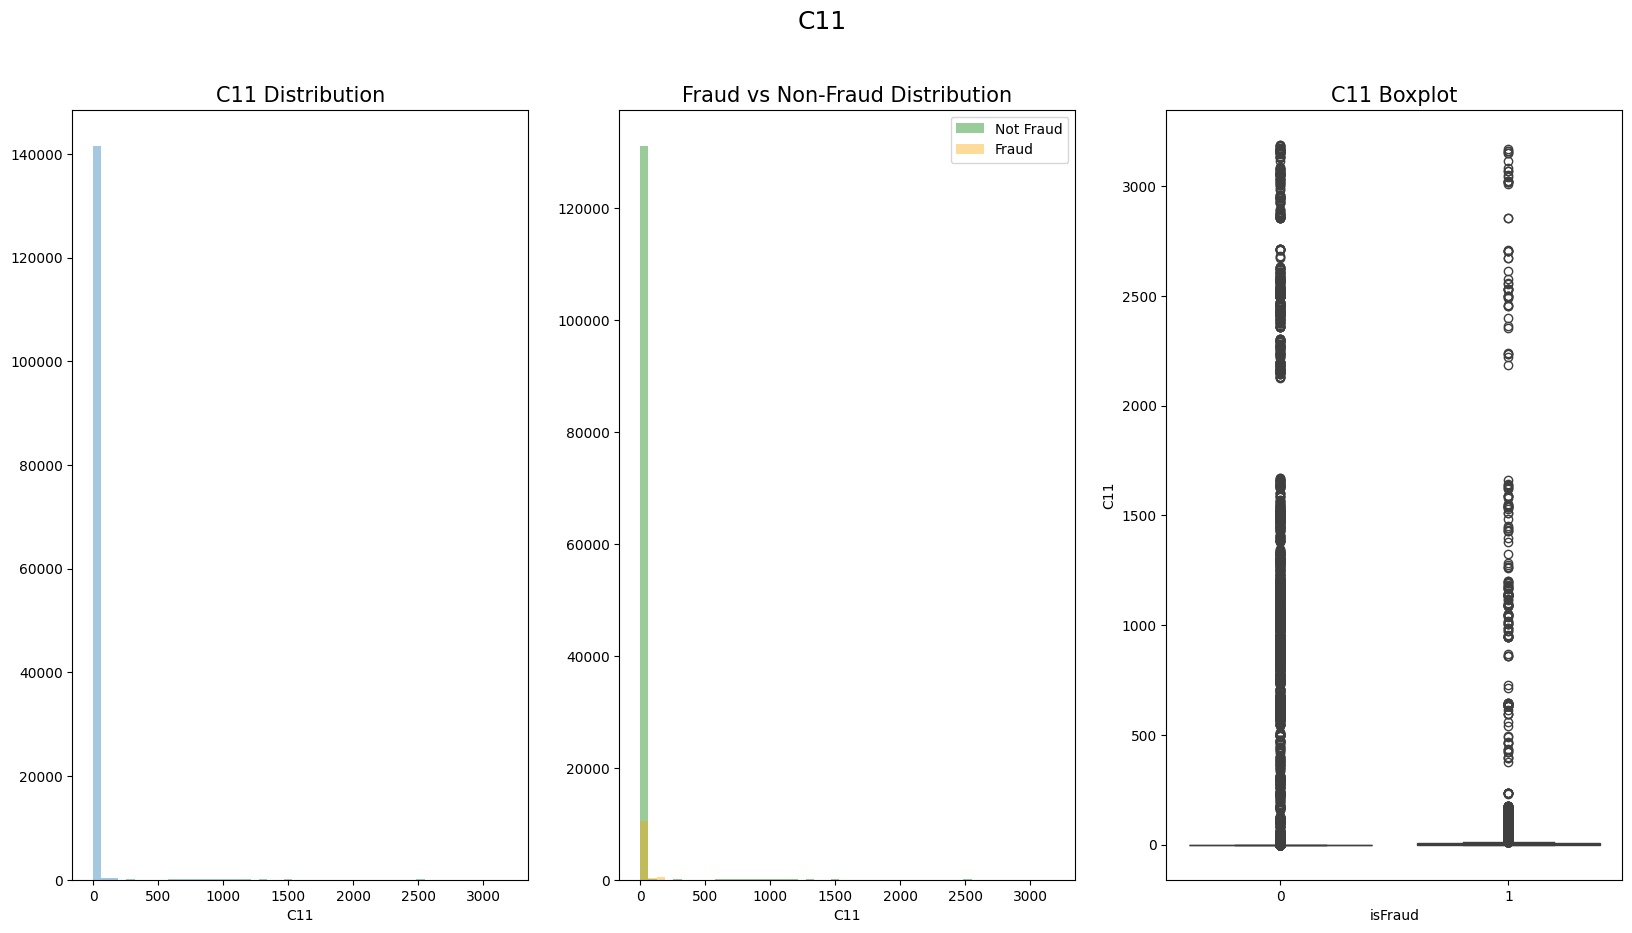

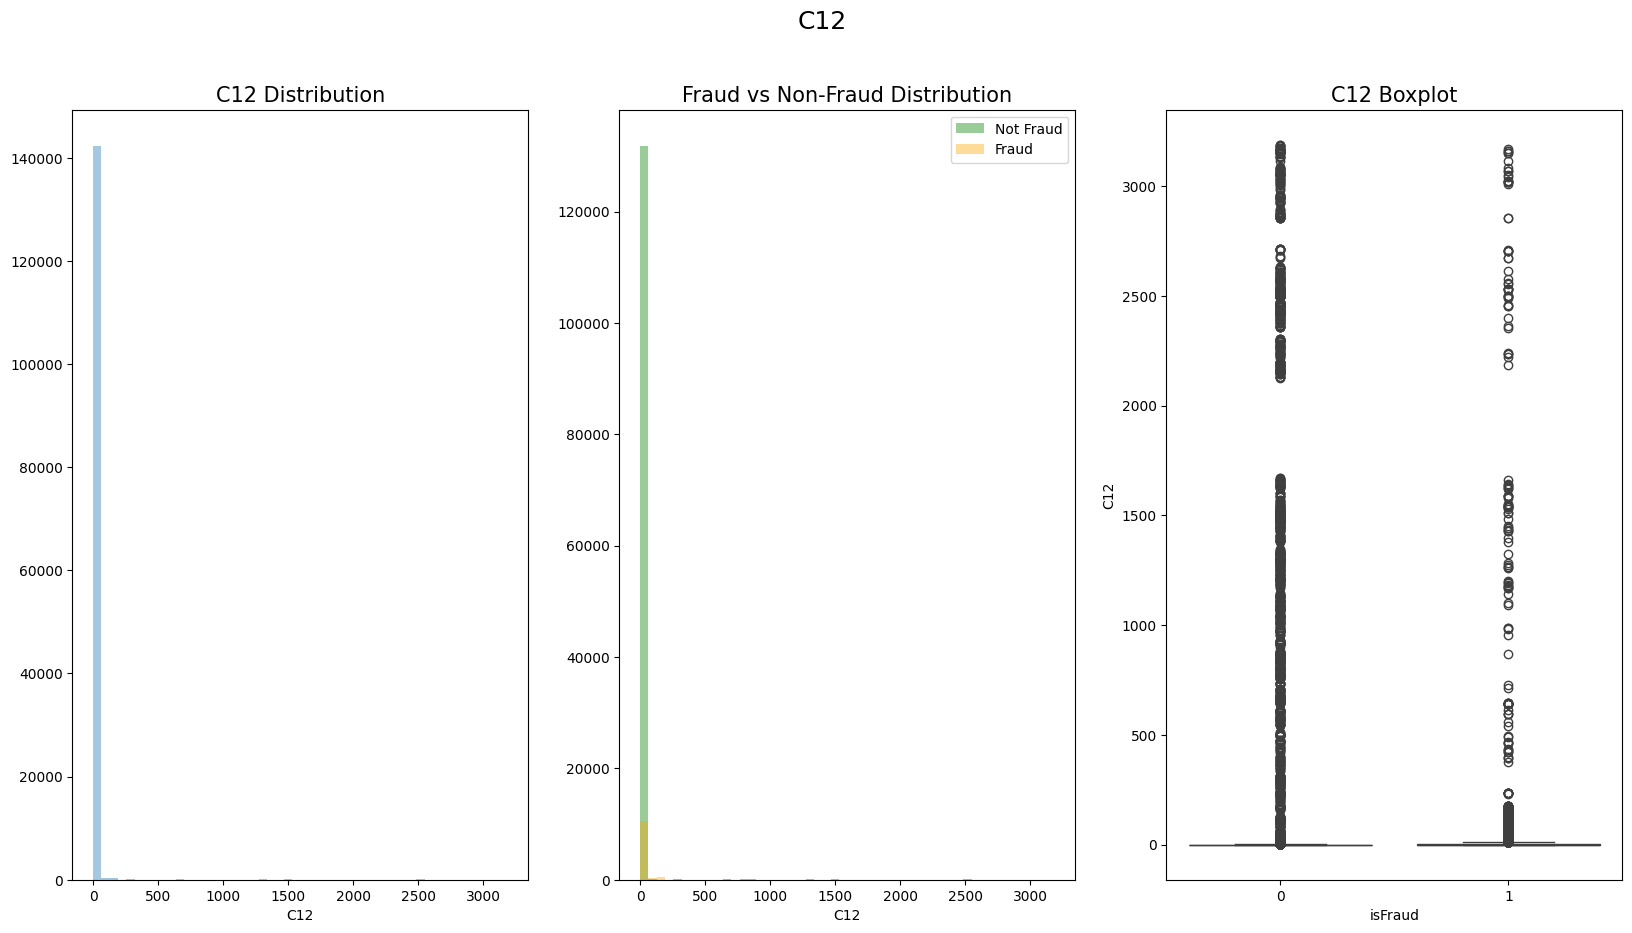

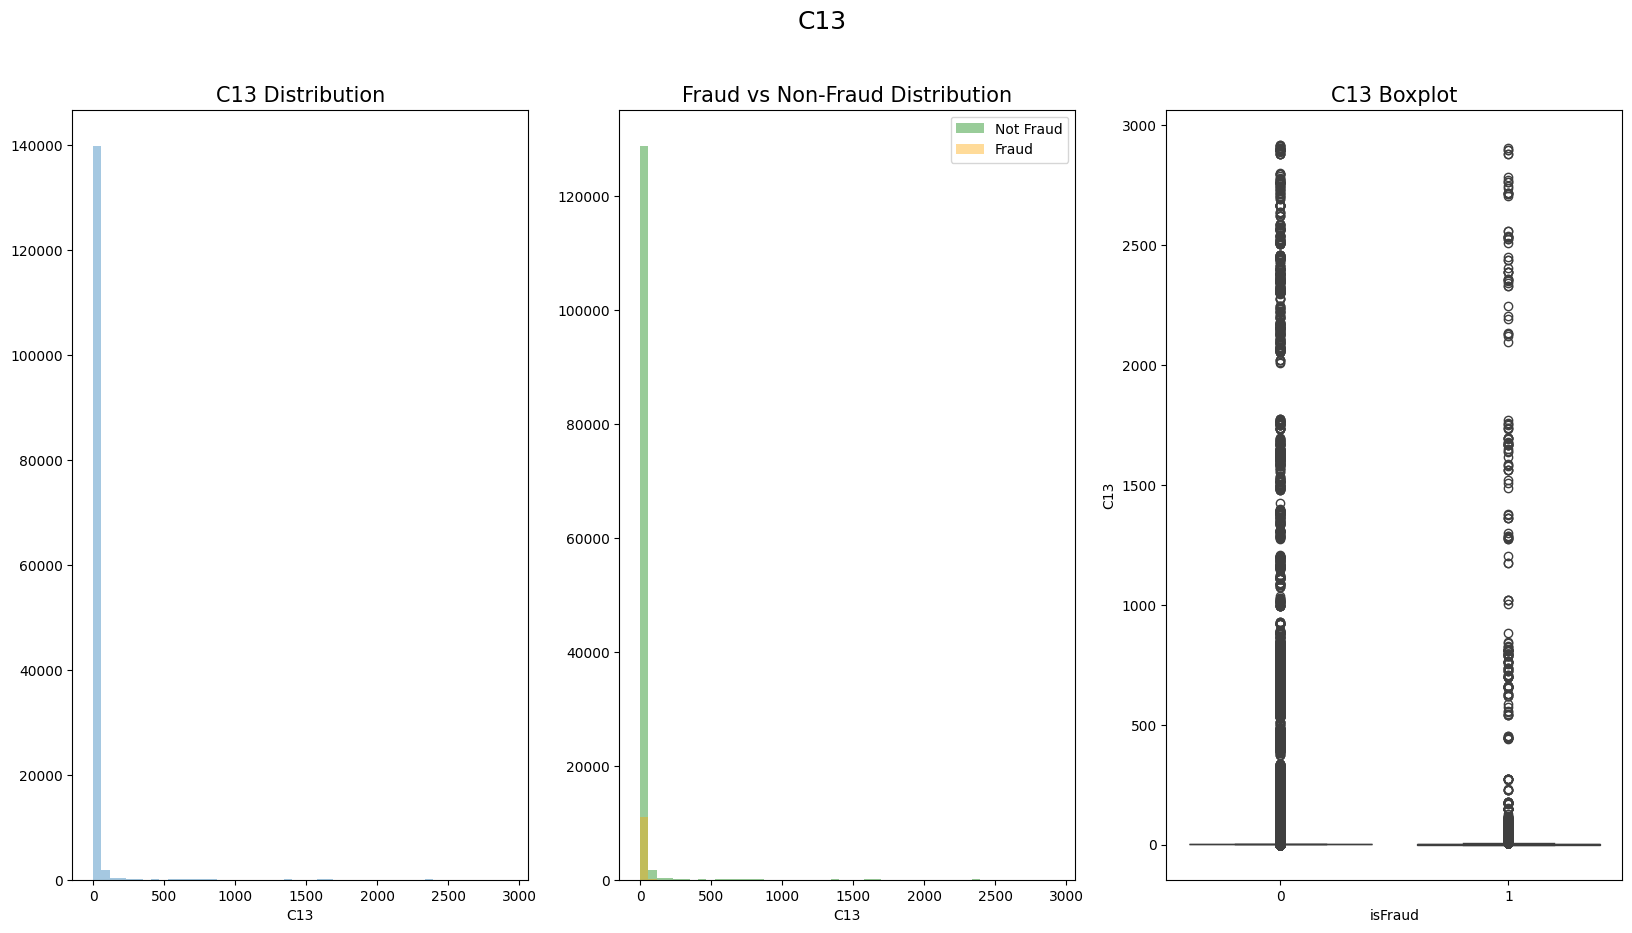

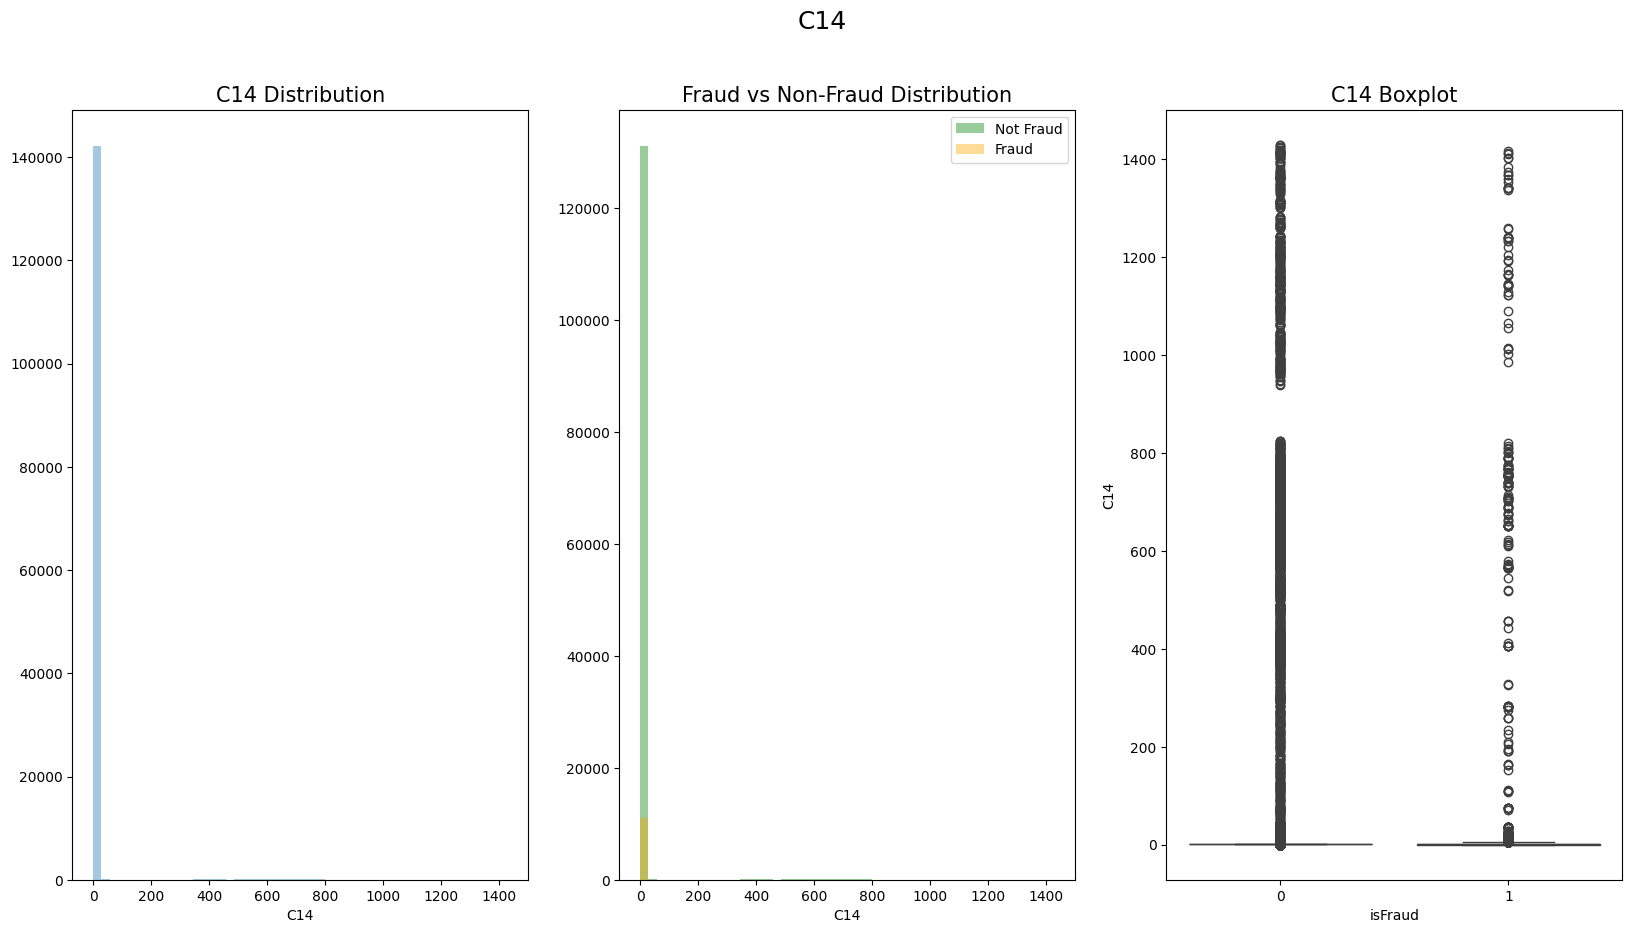

In [ ]:
id_list = train_df.loc[:1, 'C1':'C14'].columns

for i in id_list:
    print (num_var_viz(i))

- C5 and C9 tends to be homogenous
- The higher value of C3 tends to indicate higher chance of fraud

### D-features

In [ ]:
train_df.filter(regex = 'D').info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int32  
 1   TransactionDT  144233 non-null  int32  
 2   ProductCD      144233 non-null  object 
 3   D1             144015 non-null  float16
 4   D8             74926 non-null   float16
 5   D9             74926 non-null   float16
 6   DeviceType     144233 non-null  object 
 7   DeviceInfo     144233 non-null  object 
dtypes: float16(3), int32(2), object(3)
memory usage: 5.2+ MB


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


<ipython-input-62-931ed6565783>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], kde= False)
<ipython-input-62-931ed6565783>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['isFraud'] == 0][col], color = 'green', kde= False, label = 'Not Fraud')
<ipython-input-62-931ed6565783>:1

None


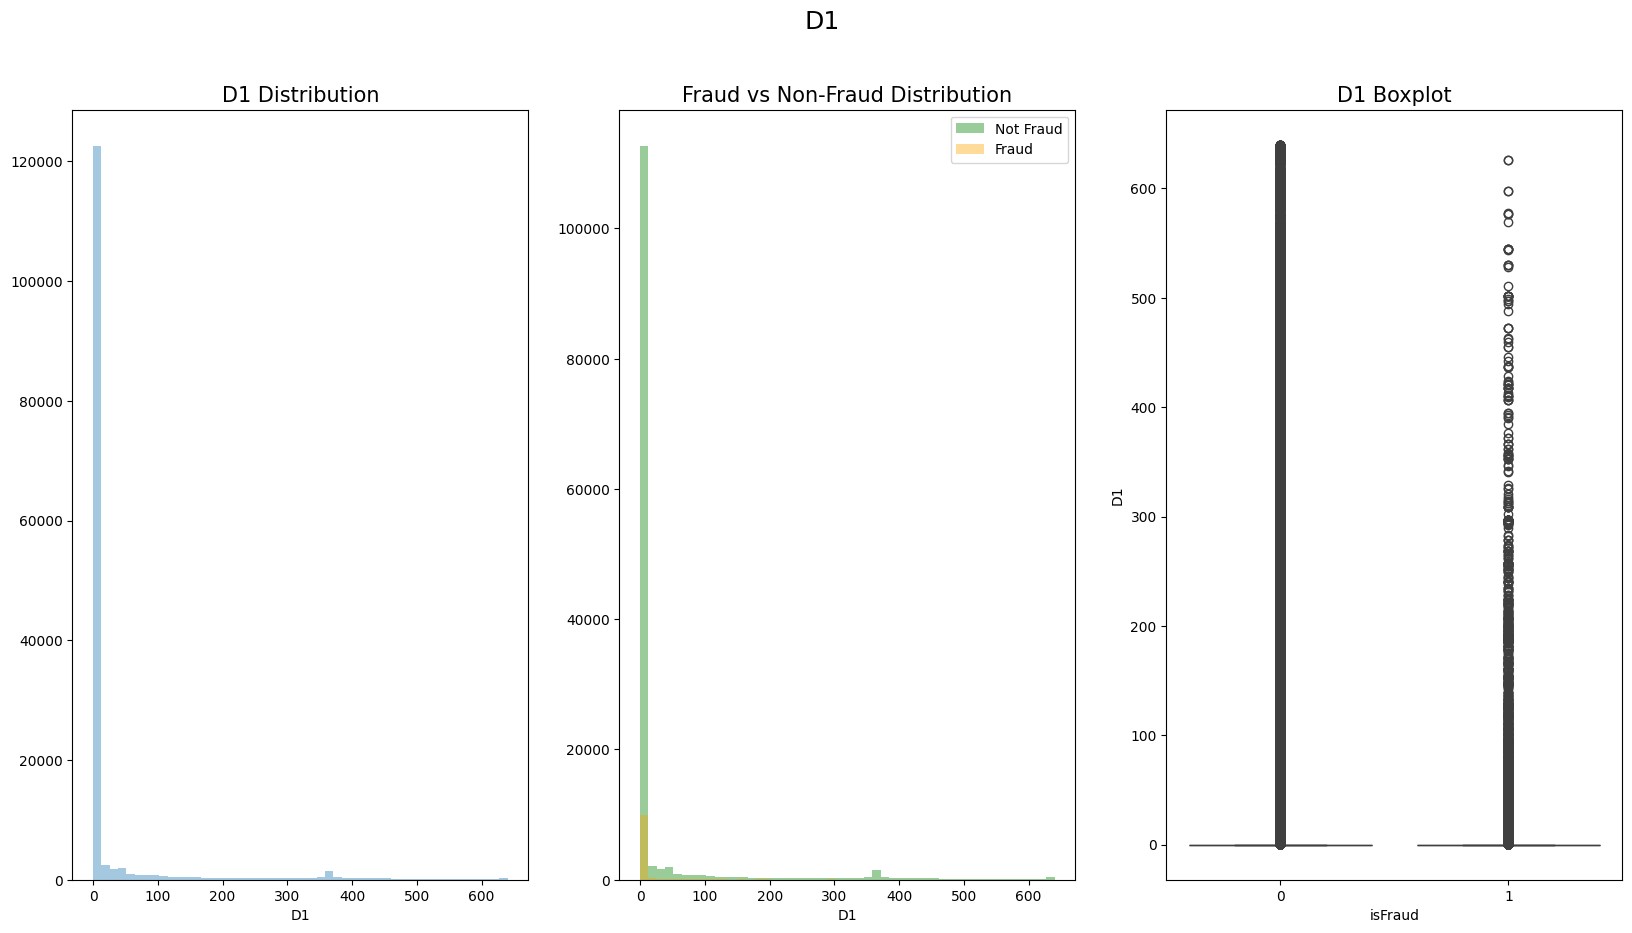

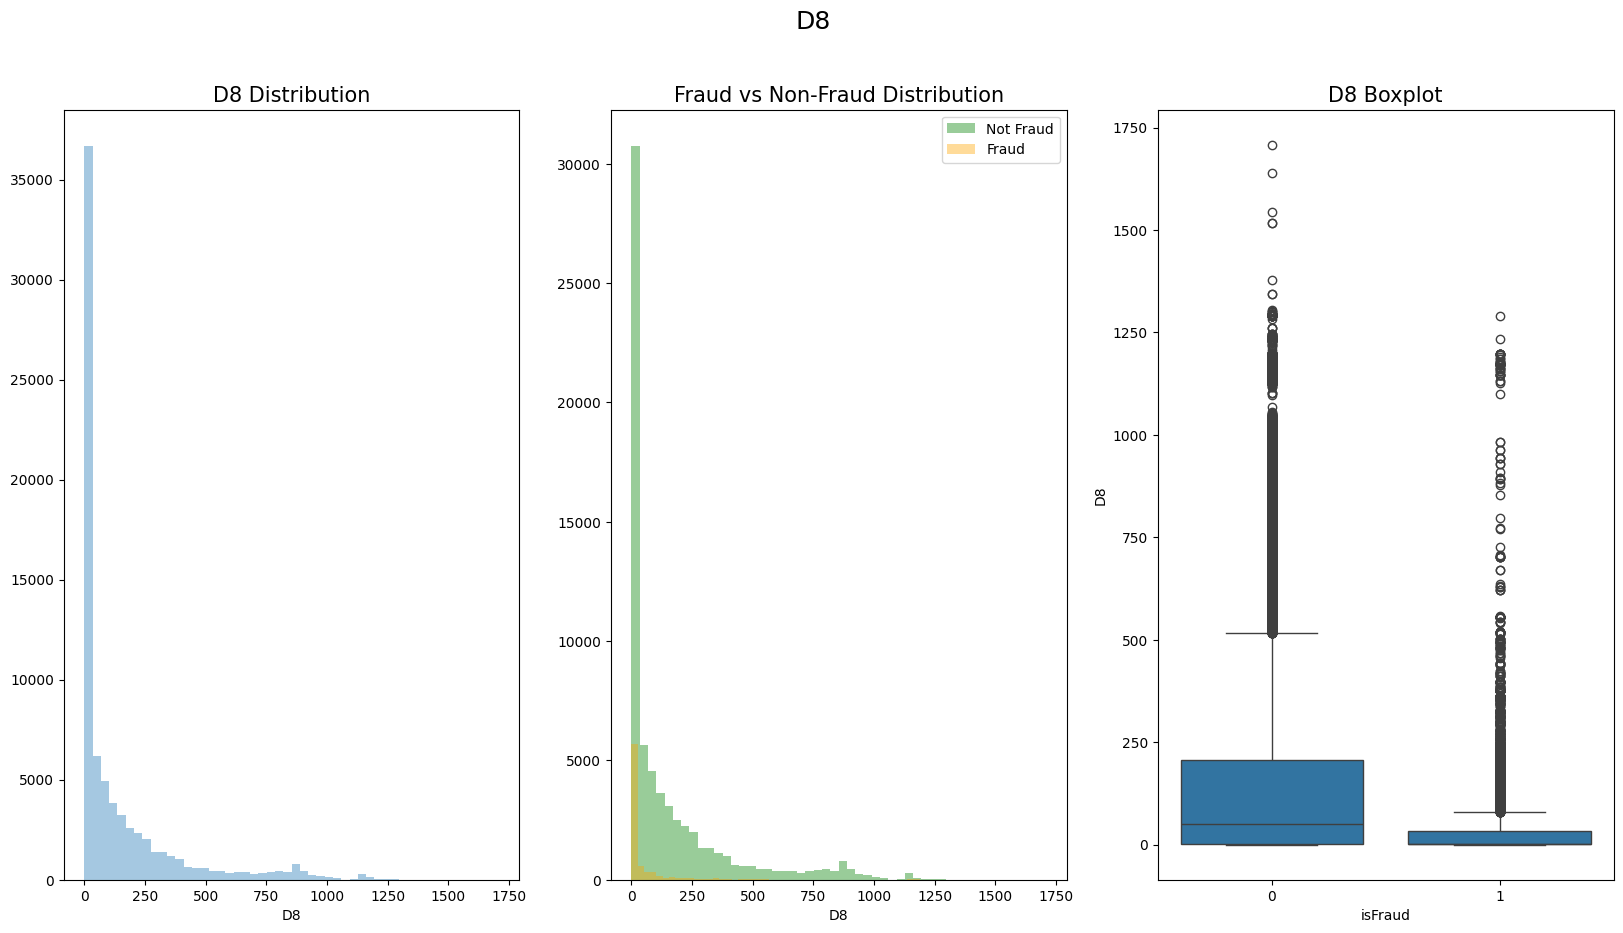

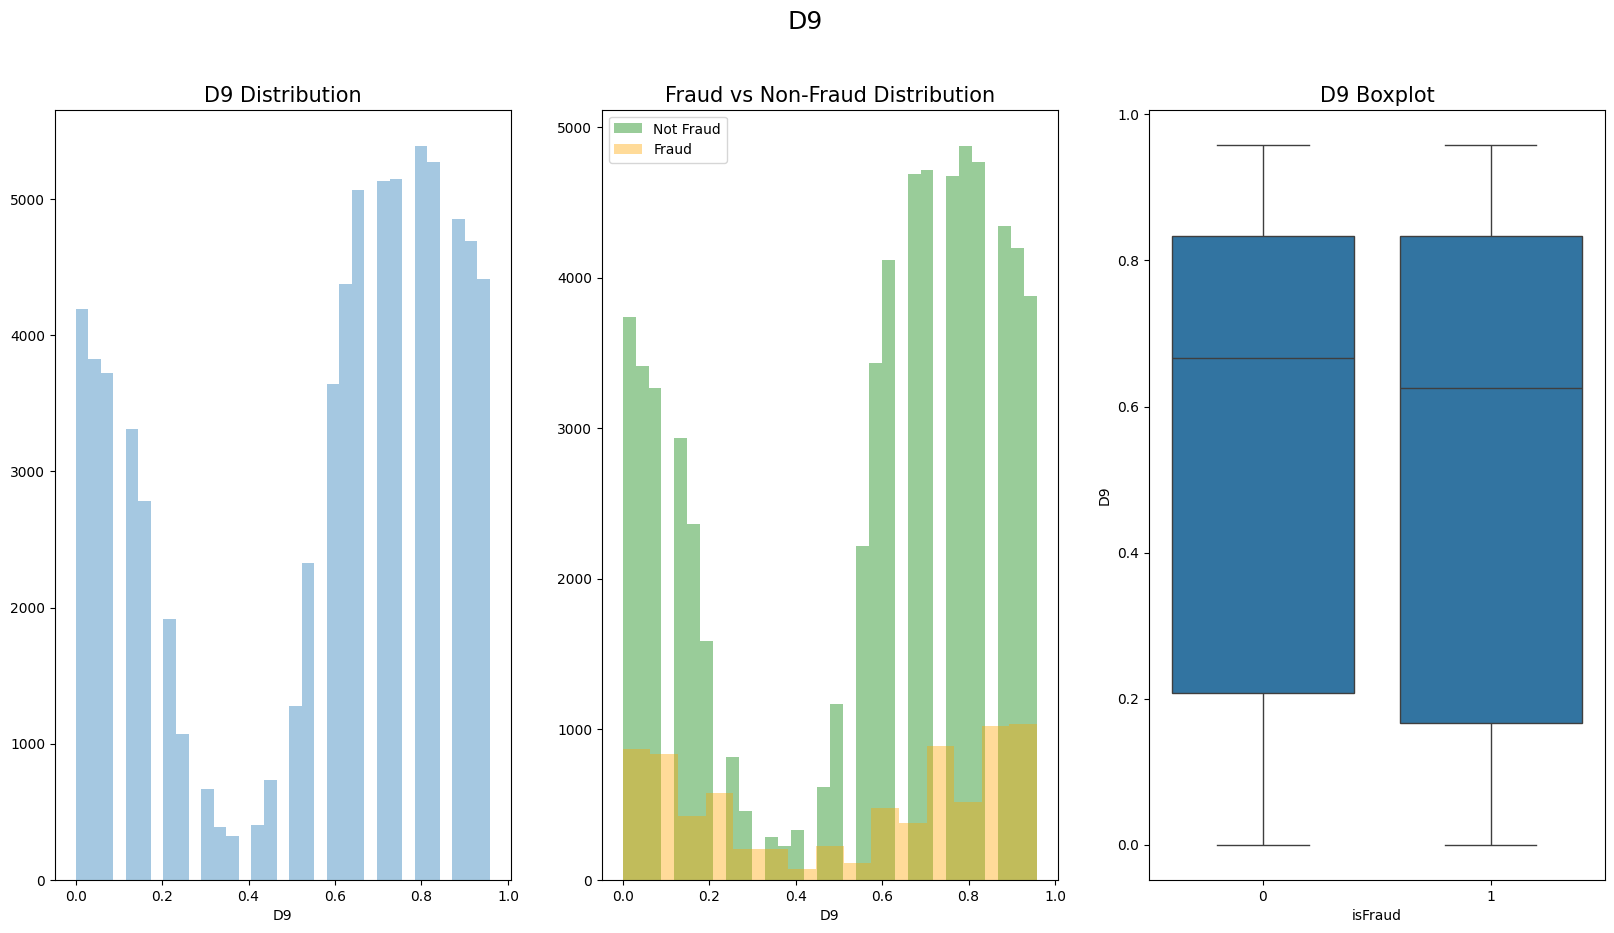

In [ ]:
id_list = ["D1", "D8", "D9"]

for i in id_list:
    print (num_var_viz(i))

-D8 covers a smaller range of value for being fraudelent

## Conclusion:

If you drop your card, it's likely the person who found it by chance and commit a fraud would spend it on consumable and essential products like grocery and gas. The perp will likely go somewhere nearby and spend a larger amount than usual before the card get locked. So perhaps we should look at user's purchase history so that any activities or purchases that deviate from normal buying habit would stand out. But we don't have identifiable data, so we can't go on this route.

If your information get hacked by careless purchases on some shady websites/gas stations, it's likely that your information will be sold to someone else who use your information for making fraud transaction. This person will make an online purchase and ship it to a distributor, who sells the good for cash and share the profit with the frauder. In this situation, the good is shipped to some far-away place from the user's home address. So the further the distance, the more a transaction looks like a fraud? No, of course not. People sends gifts all the times. But perhaps gifting 3 expensive laptops is slightly more suspicious than gifting a box of chocolate.

Feature Engineering: Combine transaction amount, type of good, and distance together.

Fraud commited by someone close to you (family member: spouse, siblings, etc). It's rare, but it could happen.

Prefered tools for committing fraud. We have learned previously in the EDA that Protonmail has exceptionally high fraud rate >95%. A quick google reveal that Proton is a email service that provide free, anonymous, end-to-end encryption email accounts. Quote from Proton website: "ProtonMail is incorporated in Switzerland and all our servers are located in Switzerland. This means all user data is protected by strict Swiss privacy laws". Meaning fraud perpetrator not only protected by the full extend of the privacy law, but also doing it at no cost. Similarly, we have other tools that also have abnormally high fraud rate such as:

Browser: Comodo IceDragon, Mozilla/Firefox?? (not firefox, but perhaps is Comodo IceDragon but recognized as another version of Firefox?)

Operating system: "other" category has fraud rate of 60%.

Phone (or browser?): Lanix Ilium

Feature Engineering: New features that emphasize the importance of these tools

Time of operation. Just like any other jobs, frauders operate at routinely hours that perhaps different from the real users. It is strange, at least to me, to make purchase decision to buy an iphone at 3 in the morning. Again, without historical data, this approach is dead in the egg.




# **3. Modeling**

We decide to use the following Machine Learning and Deep Learning techniques to find the best model predicting the chance for a transaction to be fraudulent based on its factors. All of those Data Mining techniques, except for Neural networks would be evaluated using k-fold cross-validation. Afterward, the final model would be determined based on the one with the highest macro F1-score, which is the harmonic mean of average precision and average recall metrics since the data is imbalanced with the majority of non-fraud observations.

In [ ]:
num_cols = ['TransactionAmt','C3', 'D8']
cat_cols = ['ProductCD','DeviceType','Popular OS_grouped','card4', 'P_emaildomain_grouped', 'Browser_grouped', 'DeviceInfo_grouped']
label = train_df["isFraud"]
features = train_df.drop("isFraud", axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1, stratify=label)

In [ ]:
numerical_process = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_process = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_process, num_cols),
        ('cat', categorical_process, cat_cols)
    ],
    remainder = 'drop')

## Logistic Regression

In [ ]:
logit_pipe = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'clf__solver': ['saga', 'lbfgs'],      # Solver for optimization
}



In [ ]:
from sklearn import set_config

set_config(display='diagram')
display(logit_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TransactionAmt', 'C3',
                                                   'D8']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ProductCD', 'DeviceType',
                                                   'Popular OS_grouped',
                                                   'card4',
                                                   'P_emaildomain_grouped',
                                                   'Browser_grouped',
                                                   'DeviceInfo_grouped'])])),
                ('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression())])

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(logit_pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)
# Perform cross-validation and compute scores
# scores = cross_val_score(logit_pipe, X_train, y_train, cv=cv, scoring='accuracy')

# # Print cross-validation results
# print("Cross-Validation Accuracy Scores:", scores)
# print("Mean Accuracy:", scores.mean())
# print("Standard Deviation:", scores.std())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best Parameters: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}
Best Accuracy Score: 0.6788518682520993


In [ ]:

# Fit the pipeline on the training data
logit_pipe.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit_pipe.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.6723056123687039
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79     26583
           1       0.16      0.75      0.27      2264

    accuracy                           0.67     28847
   macro avg       0.57      0.71      0.53     28847
weighted avg       0.91      0.67      0.75     28847



## SVM

In [ ]:
logit_svm = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC(random_state=42))
])

param_grid = {'clf__C': [0.1, 1, 10, 100],
              'clf__gamma': [1, 0.1, 0.01],
              'clf__kernel': ['rbf', 'poly']}

In [ ]:
from sklearn import set_config

set_config(display='diagram')
display(logit_svm)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TransactionAmt', 'C3',
                                                   'D8']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['ProductCD', 'DeviceType',
                                                   'Popular OS_grouped',
                                                   'card4',
                                                   'P_emaildomain_grouped',
                                                   'Browser_grouped',
                                                   'DeviceInfo_grouped'])])),
                ('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf', SVC(random_state=42))])

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(logit_svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)
# Perform cross-validation and compute scores
# scores = cross_val_score(logit_pipe, X_train, y_train, cv=cv, scoring='accuracy')

# # Print cross-validation results
# print("Cross-Validation Accuracy Scores:", scores)
# print("Mean Accuracy:", scores.mean())
# print("Standard Deviation:", scores.std())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:

# Fit the pipeline on the training data
logit_svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit_svm.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
new_chosen = ['TransactionAmt','dist1','card1','card2','card3','card5',
                 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8','C9', 'C10', 'C11', 'C12', 'C13', 'C14','isFraud']
cat_chosen = ['card4','Popular OS_grouped','P_emaildomain']

## Decision Tree

In [ ]:
logit_dt = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {'clf__criterion' :['gini', 'entropy'],
              'clf__max_depth' : [5, 10],
              'clf__min_samples_leaf': [10,20,30]
             }

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(logit_dt, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)
# Perform cross-validation and compute scores
# scores = cross_val_score(logit_pipe, X_train, y_train, cv=cv, scoring='accuracy')

# # Print cross-validation results
# print("Cross-Validation Accuracy Scores:", scores)
# print("Mean Accuracy:", scores.mean())
# print("Standard Deviation:", scores.std())

In [ ]:

# Fit the pipeline on the training data
logit_dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logit_dt.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

**Neural Network**

Moreover, to find a better optimal solution for the problem, we decide to use a Simple Neural Network with the first hidden layer contains the number of nodes equal the dimension of the input factor matrix in which each node process an exploration on a specific feature), then using the Sigmoid activation function to get the probability of being fraudulent of a transaction for classification process in last hidden layer. In terms of setting up the neural networks, we use ADAM optimizer, which is the combination of Momentum and RMSprop optimizer, for our optimization problem, updating the weights with a batch size of 64 for 200 epochs.


In [ ]:
# define baseline model
# create model
model = Sequential()
model.add(Dense(20, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 200
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.fit(x=features_train,y=label_train,batch_size=64,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.

Epoch 1/200
7382/7382 [==============================] - 11s 1ms/step - loss: 1.2333 - accuracy: 0.9455
Epoch 2/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.8017 - accuracy: 0.9498
Epoch 3/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.7895 - accuracy: 0.9495
Epoch 4/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.7233 - accuracy: 0.9510
Epoch 5/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.7400 - accuracy: 0.9509
Epoch 6/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.6466 - accuracy: 0.9526
Epoch 7/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.6130 - accuracy: 0.9554
Epoch 8/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.5862 - accuracy: 0.9548
Epoch 9/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.5556 - accuracy: 0.9560
Epoch 10/200
7382/7382 [==============================] - 11s 1m

In [ ]:
model.save("fraud_net.h5")

In [ ]:
my_model = tf.keras.models.load_model("fraud_net.h5")

In [ ]:
def get_pred(pred,thres):
  pred_new = []
  for ele in pred:
    if ele >= thres:
      ele = 1
    else:
      ele = 0
    pred_new.append(ele)
  return pred_new

In [ ]:
pred = model.predict(features_test)
pred = get_pred(pred,0.4)
print(classification_report(label_test, pred))
print('Confusion Matrix:')
print(confusion_matrix(label_test, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     56966
           1       0.86      0.24      0.37      2088

    accuracy                           0.97     59054
   macro avg       0.92      0.62      0.68     59054
weighted avg       0.97      0.97      0.96     59054

Confusion Matrix:
[[56886    80]
 [ 1588   500]]


**Decision tree and Importance score**

The Decision Tree splits the classification questions into sub-questions, in which the ultimate response would occur when no further gain of information could be made from a tree. We used Gini impurity to assess the training process of the model. On the other hand, the top 10 most important features to the response variables would be chosen after running the decision trees.

In [ ]:
final_trans.columns.values

array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype=object)

In [ ]:
features_train.shape

(472432, 24)

In [ ]:
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=1)

Feature: 0, Score: 0.13488
Feature: 1, Score: 0.01881
Feature: 2, Score: 0.11510
Feature: 3, Score: 0.08024
Feature: 4, Score: 0.00819
Feature: 5, Score: 0.01114
Feature: 6, Score: 0.02690
Feature: 7, Score: 0.01043
Feature: 8, Score: 0.04445
Feature: 9, Score: 0.05477
Feature: 10, Score: 0.12592
Feature: 11, Score: 0.03987
Feature: 12, Score: 0.00086
Feature: 13, Score: 0.01583
Feature: 14, Score: 0.00671
Feature: 15, Score: 0.02404
Feature: 16, Score: 0.06436
Feature: 17, Score: 0.02051
Feature: 18, Score: 0.02852
Feature: 19, Score: 0.01487
Feature: 20, Score: 0.01687
Feature: 21, Score: 0.01530
Feature: 22, Score: 0.07952
Feature: 23, Score: 0.04192


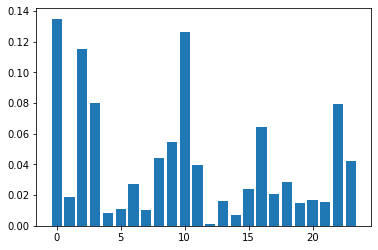

In [ ]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(features_train, label_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
most_important = sorted(range(len(importance)), key=lambda i: importance[i])[-10:]
most_important

[11, 23, 8, 9, 16, 22, 3, 2, 10, 0]

In [ ]:
train_svm.columns[most_important]

Index(['C2', 'C14', 'dist1', 'P_emaildomain', 'C7', 'C13', 'card2', 'card1',
       'C1', 'TransactionAmt'],
      dtype='object')